In [230]:
bay = {
    "stack1": [("c1",  4), ("c2", 4)],
    "stack2": [("c3",  1), ("c4", 5)],
    "stack3": [("c5",  5), ("c6", 1), ("c7", 4), ("c8", 1)],
    "stack4": [("c9",  2), ("c10", 5), ("c11", 3)],
    "stack5": [("c12", 3), ("c13", 2)]
}

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [314]:
#Functions
def calculate_u_c(bay, container):
    # Get the stack and the index of the container
    stack, index = get_container_position(bay, container)
    if index is None or index == 0:  # If the container is not in the stack or it's at the bottom
        return float('inf')
    else:
        return min(c[1] for c in bay[stack][:index])  # Return the smallest time frame of the containers below

def get_container_time(bay, container):
    for stack in bay.values():
        for c, t in stack:
            if c == container:
                return t
    return None

    # Function to get container position
def get_container_position(bay, container_id):
    for stack_name, stack in bay.items():
        for position, (id, _) in enumerate(stack):
            if id == container_id:
                return stack_name, position
    return None, None

def calculate_q_values(bay):
    # Initialize q_values dictionary
    q_values = {stack_name: [] for stack_name in bay.keys()}

    # Calculate q(c) for each container in the bay
    for stack_name, stack in bay.items():
        for i, container in enumerate(stack):
            if i == 0:  # no container underneath
                u_c = float('inf')  # assign it to infinity
            else:
                u_c = min(time_window for _, time_window in stack[:i])  # Smallest time frame of containers underneath c

            t_c = container[1]  # t(c) is the time window of the container
            if u_c > t_c:
                q_c = 1
            elif u_c == t_c:
                q_c = 2
            elif u_c > min_h_s(bay) or t_c < max_l_s(bay):
                q_c = 3
            else:
                q_c = 4

            # Add to q_values
            q_values[stack_name].append(q_c)
    return q_values

def calculate_expected_relocation_moves(bay):
    # Calculate q_values
    q_values = calculate_q_values(bay)

    # Calculate and return the total expected relocation moves for the entire bay
    return sum(1.4 if q_c == 4 else 1 if q_c == 3 else 0.5 if q_c == 2 else 0 
               for stack_name in bay.keys() 
               for q_c in q_values[stack_name])

def calculate_expected_moves(bay, stack):
    # Calculate q_values
    q_values = calculate_q_values(bay)

    # Calculate and return the expected moves for a stack
    return sum(1.4 if q_c == 4 else 1 if q_c == 3 else 0.5 if q_c == 2 else 0 for q_c in q_values[stack])

# Functions to compute the minimum of the largest time frames and the maximum of the smallest time frames
#def min_h_s(bay):
#    return min(max(time_window for _, time_window in stack) for stack in bay.values())

#def max_l_s(bay):
#    return max(min(time_window for _, time_window in stack) for stack in bay.values())

def min_h_s(bay):
    return min(max(time_window for _, time_window in stack) if stack else 0 for stack in bay.values())

def max_l_s(bay):
    return max(min(time_window for _, time_window in stack) if stack else 0 for stack in bay.values())


def plot_bay(bay):
    fig, ax = plt.subplots()

    colors = ['cyan', 'lightgreen', 'yellow', 'pink', 'orange']  # add more colors if needed

    for i, (stack_name, stack) in enumerate(bay.items()):
        bottom = 0
        for j, (container_id, container_time) in enumerate(stack):
            ax.bar(i, 1, bottom=bottom, color=colors[container_time - 1], edgecolor='black', width=1)
            ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
            bottom += 1

    ax.set_xticks(np.arange(len(bay)))
    ax.set_xticklabels(bay.keys())

    # Setting y ticks as 'Tier 1', 'Tier 2', etc.
    ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
    ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

    # Removing x-axis ticks for a cleaner look
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)  # labels along the bottom edge are off

    ax.set_xlim(left=-0.5)  # adjust the x-axis limit to remove the gap
    plt.show()
    
def get_smallest_time_frame(stack):
    if not stack:  # The stack is empty
        return float('inf')
    else:
        return min([c[1] for c in stack])


def get_containers_below(bay, container):
    # Get the stack of the container
    stack = next((stack for stack, containers in bay.items() if any(c[0] == container for c in containers)), None)
    # Get the position of the container in the stack
    container_position = next((index for index, c in enumerate(bay[stack]) if c[0] == container), None)
    # Get all the containers below the specified container in the stack
    containers_below = [c[0] for index, c in enumerate(bay[stack]) if index < container_position]
    return containers_below

def is_correctly_placed(bay, container_c):
    # Identify the current stack of the container c (s_c) and its position (p_c)
    s_c, p_c = get_container_position(bay, container_c)
    t_c = get_container_time(bay, container_c)  # get the time window of the container c

    # Get all the containers below c in stack s_c
    containers_below_c = get_containers_below(bay, container_c)

    # Check if all containers below c have a larger time frame
    for container in containers_below_c:
        if get_container_time(bay, container) <= t_c:
            return False  # c is incorrectly placed

    return True  # If all conditions are met, c is correctly placed

In [371]:
def select_stack_for_relocation(bay, exclude_stacks, c_prime, t_c_prime, α, λ1, λ2, H):
    # If there exists a stack s' in S \ exclude_stacks for which n(s') < H and l(s') > t(c') and f(B, s') <= α
    
    available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks and get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]
    
    if available_stacks:
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        # Select λ1 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ1]
        print('selecting from  stacks with reloc moves < α ')
    else:
        # If no valid stacks, select one with the smallest minimum time frame
        available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks]
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        # Select λ2 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ2]
        print('selecting from stacks with len(stack) < H and stack_name not in exclude_stack')
    # Select a stack randomly
    if selected_stacks:  # Check if the list is not empty
        s_double_prime = random.choice(selected_stacks)
    else:
        s_double_prime = None
    print('available stack for relocation : ', available_stacks)
    
    print('lambda_2 selected stack for relocation : ',selected_stacks)
    print('s_double_prime: ', s_double_prime)
    return s_double_prime

def select_stack_for_c(bay, s_c, H):
    # Find the available stacks for moving container c
    available_stacks = [s for s in bay.keys() if s != s_c and len(bay[s]) < H]
    
    # If no stacks are available, return None
    if not available_stacks:
        return None

    # Find the stack with the highest number of containers
    highest_stack = max(available_stacks, key=lambda s: len(bay[s]))
    print('available stack for c : ', available_stacks)
    print('highest stack for c : ',highest_stack)
    return highest_stack

In [5]:
def preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H):
    print("====================")
    print('algorithm 4 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    S1 = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    print('S1:', S1)
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and not is_correctly_placed(bay, c[0])}
    S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and get_container_time(bay,c[0])<t_c}

    print('S2:' ,S2)
    
    
    while S1:
        print('==for S1== ')
        c_prime = max(S1, key=S1.get) #top container
        t_c_prime = get_container_time(bay, c_prime) #get time of the container

        # Select s'' for relocation
        excluded_stacks=s_c
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return P,bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime] #or pop?

        # Update pre-processing moves and S1
        P.append((s_c, s_double_prime))
        S1.pop(c_prime)
    
    print("==for c==")
    # Move container c to the highest stack s''' with n (s''') < H
    stack_triple_prime = select_stack_for_c(bay, s_c, H)
    print('available stack for temporary relocation of c: ', stack_triple_prime)
    if stack_triple_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
        return [],bay
    bay_copy[stack_triple_prime].append((container_c, t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]  # remove container c from the stack
    P.append((s_c, stack_triple_prime))
    
    
    while S2:
        print('==for S2== ')
        c_prime = max(S2, key=S2.get)
        t_c_prime = get_container_time(bay, c_prime)
        # Select s'' for relocation
        excluded_stacks=[s_c,stack_triple_prime]
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [],bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S2
        P.append((s_c, s_double_prime))
        S2.pop(c_prime)

    # Move container c to stack s
    bay_copy[s_c].append((container_c, t_c))
    bay_copy[stack_triple_prime] = [c for c in bay_copy[stack_triple_prime] if c[0] != container_c]
    P.append((stack_triple_prime, s_c))

    return P, bay_copy


# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and stack
container_c = 'c4'
#stack_s = 'stack3'

# Define α, λ1, λ2, H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Test Algorithm 4
P, bay = preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 4 is used
S1: {}
S2: {'c3': 0}
==for c==
available stack for c :  ['stack1', 'stack3', 'stack4', 'stack5']
highest stack for c :  stack3
available stack for temporary relocation of c:  stack3
==for S2== 
available stack for relocation :  ['stack1', 'stack5']
lambda_2 selected stack for relocation :  ['stack5', 'stack1']
s_double_prime:  stack5
The pre-processing moves: [('stack2', 'stack3'), ('stack2', 'stack5'), ('stack3', 'stack2')]
The updated bay: {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2), ('c3', 1)]}


In [6]:
def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            c_prime = m
            M_c.pop(c_prime)
            p_1 = stack_s
        else:
            c_prime = o
            O_c.pop(c_prime)
            p_1 = s_c

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [], bay
        
        if s_double_prime is not None:
            bay_copy[s_double_prime].append((c_prime, t_c_prime))
            bay_copy[p_1] = [c for c in bay_copy[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))

    # Move container c to the destination stack and update the bay
    bay_copy[stack_s].append((container_c,t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))

    return P, bay_copy
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and destination stack
container_c = 'c4'
stack_s = 'stack1'

# Define α, λ1, λ2, H3
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Apply Algorithm 3
P, bay = preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 3 is used
Set O_c: {}
Set M_c: {'c1': 0, 'c2': 1}
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 selected stack for relocation :  ['stack3', 'stack4', 'stack5']
s_double_prime:  stack4
available stack for relocation :  ['stack3', 'stack4', 'stack5']
lambda_2 selected stack for relocation :  ['stack3', 'stack4', 'stack5']
s_double_prime:  stack5
The pre-processing moves: [('stack1', 'stack4'), ('stack1', 'stack5'), ('stack2', 'stack1')]
The updated bay: {'stack1': [('c4', 5)], 'stack2': [('c3', 1)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3), ('c2', 4)], 'stack5': [('c12', 3), ('c13', 2), ('c1', 4)]}


In [9]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

In [10]:
calculate_q_values(bay)

{'stack1': [1, 2],
 'stack2': [1, 4],
 'stack3': [1, 1, 4, 2],
 'stack4': [1, 4, 3],
 'stack5': [1, 1]}

In [11]:
calculate_expected_relocation_moves(bay)

6.199999999999999

In [12]:
# Determine the maximum time frame Z in the bay


In [13]:
def is_correctly_placed(bay, container_c):
    # Identify the current stack of the container c (s_c) and its position (p_c)
    s_c, p_c = get_container_position(bay, container_c)
    t_c = get_container_time(bay, container_c)  # get the time window of the container c

    # Get all the containers below c in stack s_c
    containers_below_c = get_containers_below(bay, container_c)

    # Check if all containers below c have a larger time frame
    for container in containers_below_c:
        if get_container_time(bay, container) <= t_c:
            return False  # c is incorrectly placed

    return True  # If all conditions are met, c is correctly placed

bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}
Z= max(time for stack in bay.values() for _, time in stack)


import random
for p in range(Z, 0, -1):
        # Get the containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print(A_p)
        
        for _ in range(len(A_p)):
            # Create a list of all containers in A_p that are not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print('incorrectly placed :',incorrectly_placed_containers )
            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                print('selected incorrectly container:', c)


                A_p.remove(c)

{'c4', 'c5', 'c10'}
incorrectly placed : ['c4', 'c10']
selected incorrectly container: c4
incorrectly placed : ['c10']
selected incorrectly container: c10
incorrectly placed : []
{'c7', 'c1', 'c2'}
incorrectly placed : ['c7', 'c2']
selected incorrectly container: c2
incorrectly placed : ['c7']
selected incorrectly container: c7
incorrectly placed : []
{'c11', 'c12'}
incorrectly placed : ['c11']
selected incorrectly container: c11
incorrectly placed : []
{'c9', 'c13'}
incorrectly placed : []
incorrectly placed : []
{'c8', 'c6', 'c3'}
incorrectly placed : ['c8']
selected incorrectly container: c8
incorrectly placed : []
incorrectly placed : []


In [69]:
A_p

{'c3', 'c6'}

In [45]:
import copy
def local_search_heuristic(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    best_bay=copy.deepcopy(bay)
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get he containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)

            best_improvement = 0
            best_stack = None
            #best_bay = None
            best_bay=copy.deepcopy(bay)
            best_moves = []

            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                # Create a copy of the current bay configuration
                #bay_copy = bay.copy()
                bay_copy = copy.deepcopy(bay)

                print('bay copy: ',bay_copy)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, bay_copy = preprocessing_moves_algo3(bay_copy, c, s, α, λ1, λ2, H)
                else:
                    pre_moves, bay_copy = preprocessing_moves_algo4(bay_copy, c, α, λ1, λ2, H)

                #if pre_moves is None or bay_copy is None:  # If the move was not feasible, skip to the next iteration
                if not pre_moves:  # If the move was not feasible, skip to the next iteration
                    continue
                    
                print('pre-moves for ',s,' stack :', pre_moves)
                print('new Bay orientation for ',s,' stack :', bay_copy)
                print('original Bay orientation for ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(bay_copy)
                m_s = len(pre_moves)
                #improvement = current_moves - (α * m_s + new_moves)
                improvement = current_moves -  new_moves

                # Update the best improvement and the best destination stack
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_stack = s
                    best_bay = bay_copy
                    best_moves = pre_moves
                    print("*** improvement achieved***")
                    print("best moves: ", best_moves)
                    print("best bay :", best_bay)
            # If the best improvement is positive, update the bay configuration and the pre-processing moves
            if best_improvement >= 0:
                bay = best_bay
                P += best_moves

    return P,best_bay




In [39]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 5
Containers in  5 time window : {'c5', 'c10', 'c4'}
####################
incorrectly_placed_containers   5 time window : ['c10', 'c4']
Target Container in 5  time window : c10
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
bay:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
algorithm 3 is used
Set O_c: {'c11': 2}
Set M_c: {'c1': 0, 'c2': 1}
available stack for relocation :  ['stack2', 'stack5']
lambda_2 selected stack for relocation :  ['stack2', 'stack5']
s_double_prime:  stack5
available stack for relocation :  ['stack2', 'stack5']
lambda_2 selected stack for relocati

In [40]:
bay

{'stack1': [('c1', 4), ('c2', 4)],
 'stack2': [('c3', 1), ('c4', 5)],
 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)],
 'stack5': [('c12', 3), ('c13', 2)]}

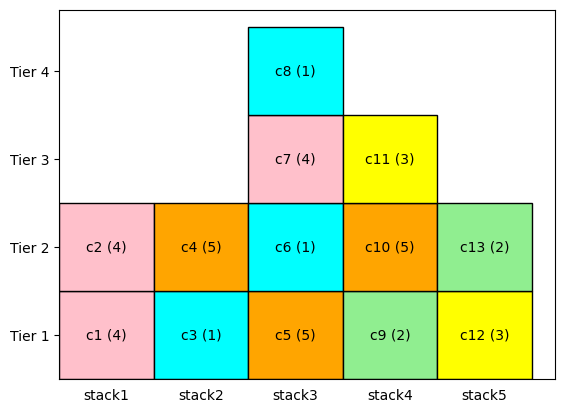

In [41]:
plot_bay(bay)

In [42]:
updated_bay

{'stack1': [('c1', 4)],
 'stack2': [('c10', 5), ('c7', 4), ('c2', 4)],
 'stack3': [('c5', 5), ('c4', 5), ('c11', 3), ('c3', 1)],
 'stack4': [('c9', 2), ('c6', 1)],
 'stack5': [('c12', 3), ('c13', 2), ('c8', 1)]}

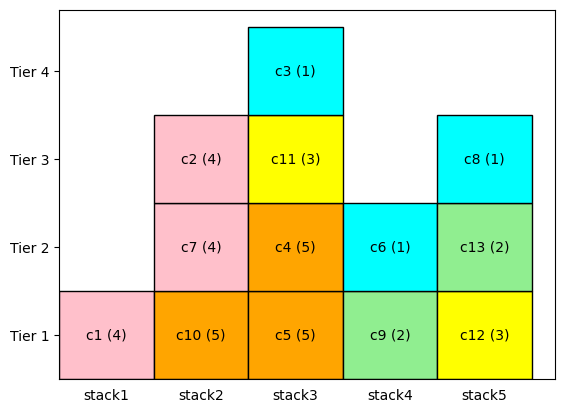

In [43]:
plot_bay(updated_bay)

In [27]:
P

[('stack2', 'stack5'),
 ('stack4', 'stack1'),
 ('stack2', 'stack5'),
 ('stack4', 'stack2'),
 ('stack3', 'stack4'),
 ('stack3', 'stack2'),
 ('stack3', 'stack1'),
 ('stack5', 'stack2'),
 ('stack5', 'stack3')]

In [173]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

bay_copy = bay.copy()

In [71]:
get_container_position(bay, 'c1')

('stack1', 0)

In [155]:
# change

def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            c_prime = m
            M_c.pop(c_prime)
            p_1 = stack_s
        else:
            c_prime = o
            O_c.pop(c_prime)
            p_1 = s_c

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            return [], bay  # Return current pre-processing moves and None to indicate that the operation was not feasible

        
        if s_double_prime is not None:
            bay[s_double_prime].append((c_prime, t_c_prime))
            bay[p_1] = [c for c in bay[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))

    # Move container c to the destination stack and update the bay
    bay[stack_s].append((container_c,t_c))
    bay[s_c] = [c for c in bay[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))

    return P, bay


In [156]:
def preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H):
    print("====================")
    print('algorithm 4 is used')
    print("====================")
    P = []
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    S1 = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    print('S1:', S1)
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and not is_correctly_placed(bay, c[0])}
    S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and get_container_time(bay,c[0])<t_c}

    print('S2:' ,S2)
    
    
    while S1:
        print('==for S1== ')
        c_prime = max(S1, key=S1.get) #top container
        t_c_prime = get_container_time(bay, c_prime) #get time of the container

        # Select s'' for relocation
        excluded_stacks=s_c
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            return [], bay  # Return current pre-processing moves and None to indicate that the operation was not feasible
        
        
        # Relocate container c' to stack s''
        bay[s_double_prime].append((c_prime, t_c_prime))
        bay[s_c] = [c for c in bay[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S1
        P.append((s_c, s_double_prime))
        S1.pop(c_prime)
    
    print("==for c==")
    # Move container c to the highest stack s''' with n (s''') < H
    stack_triple_prime = select_stack_for_c(bay, s_c, H)
    print('available stack for temporary relocation of c: ', stack_triple_prime)

    bay[stack_triple_prime].append((container_c, t_c))
    bay[s_c] = [c for c in bay[s_c] if c[0] != container_c]  # remove container c from the stack
    P.append((s_c, stack_triple_prime))
    
    

    while S2:
        print('==for S2== ')
        c_prime = max(S2, key=S2.get)
        t_c_prime = get_container_time(bay, c_prime)
        # Select s'' for relocation
        excluded_stacks=[s_c,stack_triple_prime]
        s_double_prime = select_stack_for_relocation(bay, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
  # Relocate container c' to stack s''
        bay[s_double_prime].append((c_prime, t_c_prime))
        bay[s_c] = [c for c in bay[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S2
        P.append((s_c, s_double_prime))
        S2.pop(c_prime)

    # Move container c to stack s
    bay[s_c].append((container_c, t_c))
    bay[stack_triple_prime] = [c for c in bay[stack_triple_prime] if c[0] != container_c]
    P.append((stack_triple_prime, stack_s))

    return P, bay


# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define the container and stack
container_c = 'c4'
#stack_s = 'stack3'

# Define α, λ1, λ2, H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Test Algorithm 4
P, bay = preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 4 is used
S1: {}
S2: {'c3': 0}
==for c==
available stack for c :  ['stack1', 'stack3', 'stack4', 'stack5']
highest stack for c :  stack3
available stack for temporary relocation of c:  stack3
==for S2== 
available stack for relocation :  ['stack1', 'stack5']
lambda_2 selected stack for relocation :  ['stack5', 'stack1']
s_double_prime:  stack5
The pre-processing moves: [('stack2', 'stack3'), ('stack2', 'stack5'), ('stack3', 'stack1')]
The updated bay: {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2), ('c3', 1)]}


In [117]:
import copy
def local_search_heuristic(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    best_bay={}
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get the containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)

            best_improvement = 0
            best_stack = None
            best_bay = None
            best_moves = []

            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                # Create a copy of the current bay configuration
                #bay_copy = bay.copy()
                bay_copy = copy.deepcopy(bay)

                print('bay copy: ',bay_copy)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, bay_copy = preprocessing_moves_algo3(bay_copy, c, s, α, λ1, λ2, H)
                else:
                    pre_moves, bay_copy = preprocessing_moves_algo4(bay_copy, c, α, λ1, λ2, H)

                if pre_moves is None or bay_copy is None:  # If the move was not feasible, skip to the next iteration
                    continue
                print('pre-moves for ',s,' stack :', pre_moves)
                print('new Bay orientation for ',s,' stack :', bay_copy)
                print('original Bay orientation for ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(bay_copy)
                m_s = len(pre_moves)
                #improvement = current_moves - (α * m_s + new_moves)
                improvement = current_moves -  new_moves

                # Update the best improvement and the best destination stack
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_stack = s
                    best_bay = bay_copy
                    best_moves = pre_moves
                    print("*** improvement achieved***")
                    print("best moves: ", best_moves)
                    print("best bay :", best_bay)
            # If the best improvement is positive, update the bay configuration and the pre-processing moves
            if best_improvement >= 0:
                bay = best_bay
                P += best_moves

    return P,best_bay




In [126]:
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 9
Containers in  9 time window : {"c7'"}
####################
incorrectly_placed_containers   9 time window : ["c7'"]
Target Container in 9  time window : c7'
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
bay:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {}
available stack for relocation :  ["stack2'", "stack4'"]
lambda_2 selected stack for relocation :  ["stack2'", "stack4'"]
s_double_prime:  stack4'
pre-moves for  stack1'  stack : [("stack3'", "stack4'"), ("stack3'", "stack1'")]
new Bay orientation for  stack1'  stack : {"stack1'": [("c7'", 9)], "stack2

In [127]:
bay

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [128]:
updated_bay

{"stack1'": [("c8'", 7)],
 "stack2'": [("c4'", 8), ("c5'", 7)],
 "stack3'": [("c3'", 7), ("c9'", 6), ("c1'", 4)],
 "stack4'": [("c6'", 3), ("c2'", 1)],
 "stack5'": [("c7'", 9), ("c10'", 6)]}

In [129]:
P

[("stack5'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack3'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack3'", "stack5'"),
 ("stack2'", "stack3'"),
 ("stack1'", "stack3'"),
 ("stack1'", "stack5'"),
 ("stack2'", "stack4'"),
 ("stack1'", "stack2'"),
 ("stack1'", "stack2'")]

In [49]:
import pandas as pd
import random

# Define the maximum number of containers per bay, stacks, tiers, and time windows
max_containers = 14
min_containers = 10
stacks = 5
tiers = 4
time_windows = 8

# Initialize list to store the bay data
data = []

# Generate data for 10 bays
for bay in range(1, 11):
    # Determine the number of containers in the bay
    num_containers = random.randint(min_containers, max_containers)
    
    # Create a dictionary to store used tiers for each stack
    used_tiers = {f'stack{i+1}\'': [] for i in range(stacks)}
    
    # Generate data for each container
    for container in range(1, num_containers + 1):
        container_id = f"c{container}'"
        container_location_bay = bay
        # Randomly select a stack ensuring that the selected stack is not full
        while True:
            container_location_stack = f"stack{random.randint(1, stacks)}'"
            if len(used_tiers[container_location_stack]) < tiers:
                break
        # Randomly select a tier ensuring that the selected tier is not used in the selected stack
        while True:
            container_location_tier = random.randint(0, tiers - 1)
            if container_location_tier not in used_tiers[container_location_stack]:
                used_tiers[container_location_stack].append(container_location_tier)
                break
        appointment_time = random.randint(1, time_windows + 1) if random.random() < 0.9 else 9

        # Add the container data to the list
        data.append([
            container_id,
            container_location_bay,
            container_location_stack,
            container_location_tier,
            appointment_time
        ])

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=["container_id", "container_location_bay", "container_location_stack", "container_location_tier", "appointment_time"])

# Write the DataFrame to an Excel file
df.to_excel("bays_data.xlsx", index=False, engine='openpyxl')


In [50]:
df

,container_id,container_location_bay,container_location_stack,container_location_tier,appointment_time
0,c1',1,stack4',2,9
1,c2',1,stack4',1,6
2,c3',1,stack3',1,1
3,c4',1,stack4',0,7
4,c5',1,stack3',0,8
...,...,...,...,...,...
106,c7',10,stack1',2,8
107,c8',10,stack3',1,5
108,c9',10,stack3',0,9
109,c10',10,stack5',1,2


In [53]:
import pandas as pd
import openpyxl
import copy
from openpyxl import Workbook

# function to convert dataframe to bays
def df_to_bays(df):
    bays = {}
    for idx, row in df.iterrows():
        bay = row['container_location_bay']
        stack = row['container_location_stack']
        if bay not in bays:
            bays[bay] = {}
        if stack not in bays[bay]:
            bays[bay][stack] = []
        bays[bay][stack].append((row['container_id'], row['appointment_time']))
    return bays


# function to convert bays to dataframe
def bays_to_df(bays):
    dfs = []
    for bay_id, bay in bays.items():
        df = pd.DataFrame.from_dict(bay, orient='index').reset_index()
        df = df.melt(id_vars=['index'], value_name='Container and Time')
        df[['Container', 'Time']] = pd.DataFrame(df['Container and Time'].tolist(), index=df.index)
        df = df.pivot(index='index', columns='variable', values=['Container', 'Time'])
        df.columns = df.columns.map(''.join)
        df.reset_index(inplace=True)
        df['container_location_bay'] = bay_id
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# 1. Import the Excel file
df = pd.read_excel('bays_data.xlsx')

# 2. Solve local_search_heuristics for each bay
bays = df_to_bays(df)


In [127]:
import pandas as pd

# load the data
df= pd.read_excel('bays_data.xlsx')

# display the data
#print(data)


def df_to_bays(df):
    bays = {}

    # find out the max stack number across all bays
    max_stack = df['container_location_stack'].str.extract('(\d+)').astype(int).max()[0]

    for bay in df['container_location_bay'].unique():
        bays[bay] = {}
        bay_df = df[df['container_location_bay'] == bay]

        for stack in range(1, max_stack + 1):
            stack_name = "stack" + str(stack) + "'"
            if stack_name in bay_df['container_location_stack'].values:
                bays[bay][stack_name] = list(bay_df[bay_df['container_location_stack'] == stack_name][['container_id', 'appointment_time']].to_records(index=False))
            else:
                bays[bay][stack_name] = []

    return bays


In [129]:
bays=df_to_bays(df)


In [130]:
bays

{1: {"stack1'": [("c7'", 5), ("c11'", 2)],
  "stack2'": [("c13'", 8)],
  "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
  "stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
  "stack5'": [("c8'", 7), ("c9'", 5)]},
 2: {"stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]},
 3: {"stack1'": [("c4'", 9), ("c6'", 3), ("c7'", 6), ("c11'", 2)],
  "stack2'": [("c5'", 7), ("c10'", 8)],
  "stack3'": [("c3'", 4)],
  "stack4'": [("c1'", 1)],
  "stack5'": [("c2'", 3), ("c8'", 9), ("c9'", 6)]},
 4: {"stack1'": [("c5'", 4), ("c6'", 6)],
  "stack2'": [("c3'", 9), ("c8'", 6)],
  "stack3'": [("c2'", 8), ("c4'", 5), ("c7'", 1), ("c9'", 5)],
  "stack4'": [("c10'", 3)],
  "stack5'": [("c1'", 1)]},
 5: {"stack1'": [("c1'", 9), ("c6'", 2), ("c7'", 2)],
  "stack2'": [("c2'", 8), ("c3'", 8), ("c4'", 5), ("c5'", 8)],
  "stack3'": [("c9'", 7), ("c

In [48]:
df

,container_id,container_location_bay,container_location_stack,container_location_tier,appointment_time
0,c1',1,stack3',1,6
1,c2',1,stack1',1,5
2,c3',1,stack1',3,6
3,c4',1,stack1',0,7
4,c5',1,stack1',2,2
...,...,...,...,...,...
115,c8',10,stack1',3,5
116,c9',10,stack5',3,9
117,c10',10,stack1',2,1
118,c11',10,stack2',3,3


In [58]:
bay9={"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
  "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
  "stack1'": [("c7'", 5), ("c11'", 2)],
  "stack5'": [("c8'", 7), ("c9'", 5)],
  "stack2'": [("c13'", 8)]}


In [59]:
bay1

{"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
 "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
 "stack1'": [("c7'", 5), ("c11'", 2)],
 "stack5'": [("c8'", 7), ("c9'", 5)],
 "stack2'": [("c13'", 8)]}

In [84]:
# Define the bay
bay10={"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
  "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
  "stack1'": [("c7'", 5), ("c11'", 2)],
  "stack5'": [("c8'", 7), ("c9'", 5)],
  "stack2'": [("c13'", 8)]}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 5

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay10, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 9
Containers in  9 time window : {"c12'", "c1'"}
####################
incorrectly_placed_containers   9 time window : ["c12'"]
Target Container in 9  time window : c12'
___________________________________
checkin stack : stack4'
bay copy:  {"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack1'": [("c7'", 5), ("c11'", 2)], "stack5'": [("c8'", 7), ("c9'", 5)], "stack2'": [("c13'", 8)]}
bay:  {"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack1'": [("c7'", 5), ("c11'", 2)], "stack5'": [("c8'", 7), ("c9'", 5)], "stack2'": [("c13'", 8)]}
algorithm 4 is used
S1: {}
S2: {"c2'": 1, "c4'": 2}
==for c==
available stack for c :  ["stack3'", "stack1'", "stack5'", "stack2'"]
highest stack for c :  stack3'
available stack for temporary relocation of c:  stack3'
==for S2== 
available stack for relocation :  ["stack

In [71]:
bay1

{"stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)],
 "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)],
 "stack1'": [("c7'", 5), ("c11'", 2)],
 "stack5'": [("c8'", 7), ("c9'", 5)],
 "stack2'": [("c13'", 8)]}

In [72]:
updated_bay

{"stack4'": [("c1'", 9), ("c5'", 8)],
 "stack3'": [("c12'", 9), ("c4'", 7), ("c3'", 1)],
 "stack1'": [("c7'", 5), ("c11'", 2)],
 "stack5'": [("c8'", 7), ("c9'", 5), ("c10'", 4)],
 "stack2'": [("c13'", 8), ("c6'", 7), ("c2'", 6)]}

IndexError: list index out of range

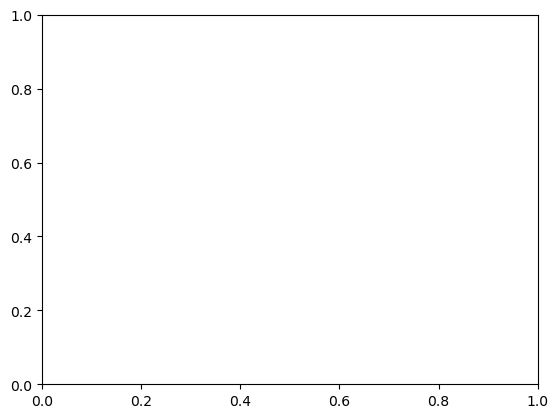

In [64]:
plot_bay(bay1)

In [69]:
import matplotlib.cm as cm

def plot_bays(bays):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    for bay_num, bay in bays.items():
        fig, ax = plt.subplots()

        for i, (stack_name, stack) in enumerate(bay.items()):
            bottom = 0
            for j, (container_id, container_time) in enumerate(stack):
                color_index = list(unique_times).index(container_time)
                ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                bottom += 1

        ax.set_xticks(np.arange(len(bay)))
        ax.set_xticklabels(bay.keys())

        ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
        ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

        plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=True)

        ax.set_xlim(left=-0.5)
        plt.title(f'Bay {bay_num}')
        plt.show()


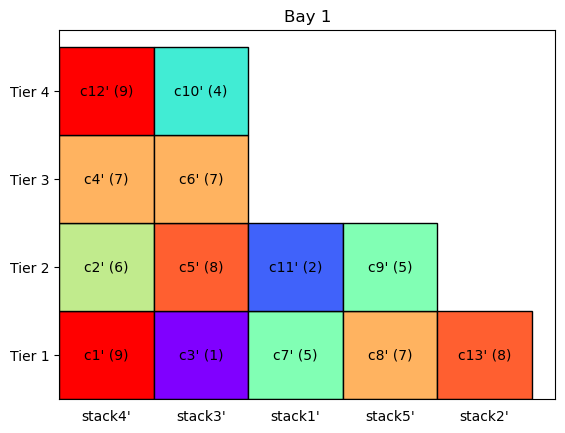

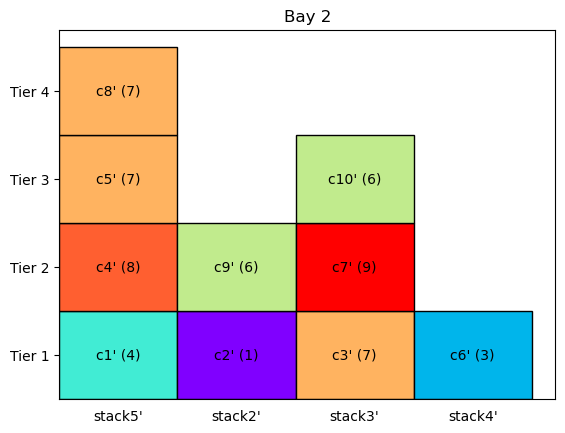

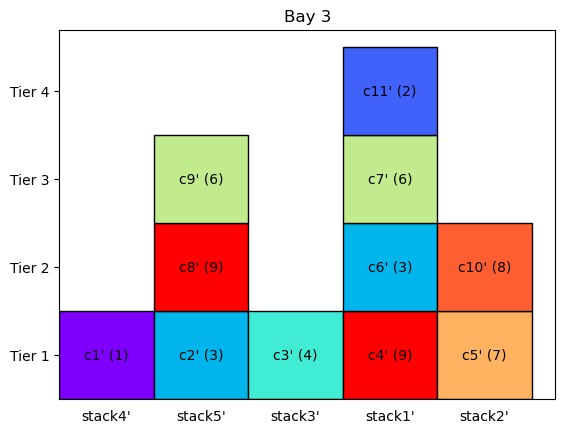

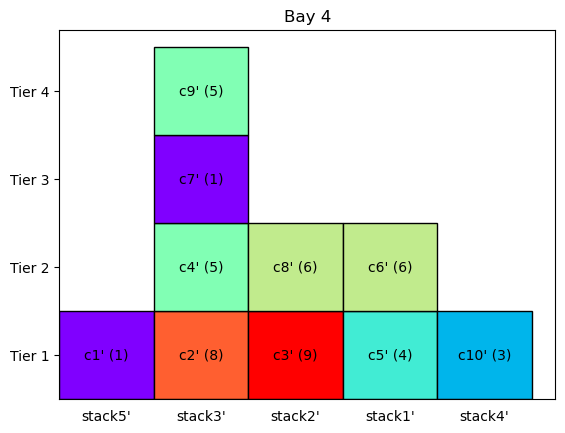

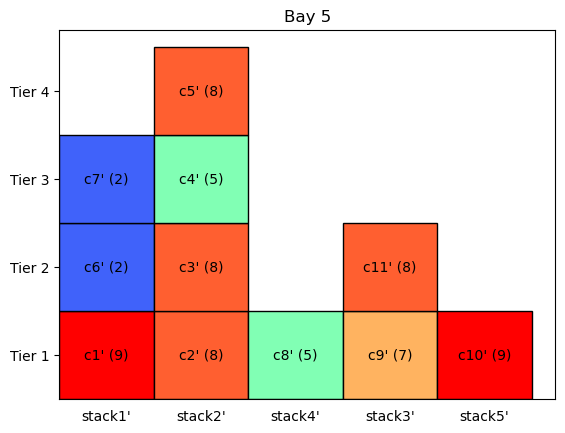

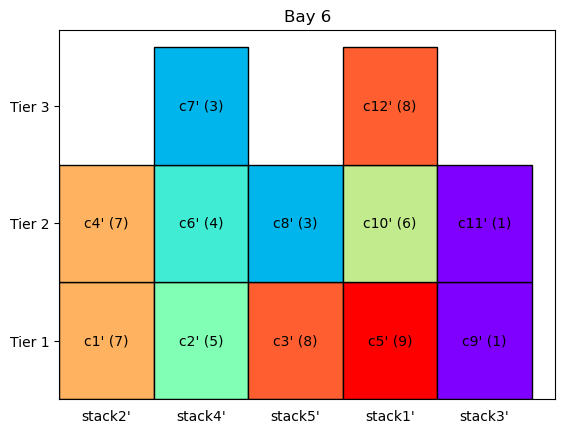

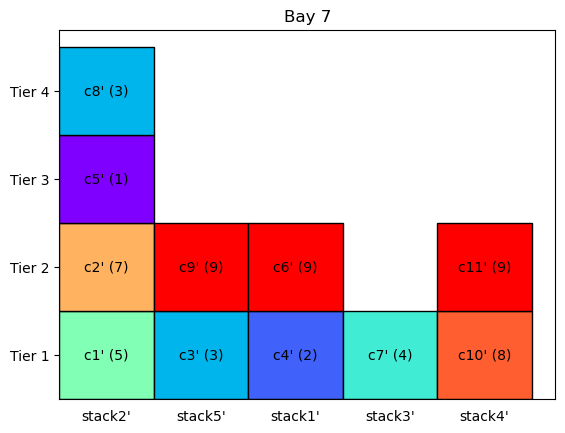

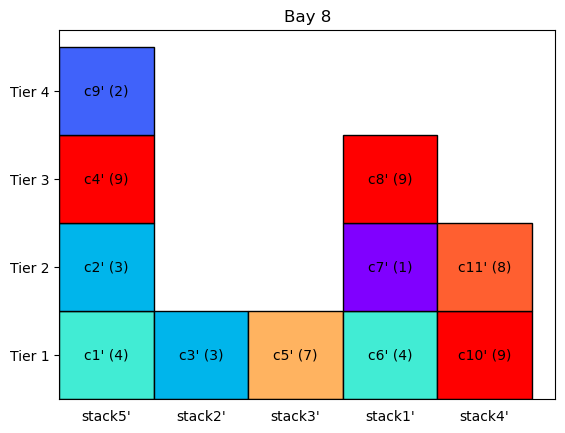

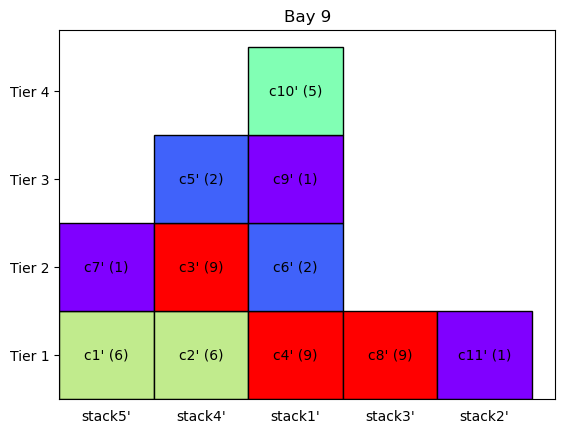

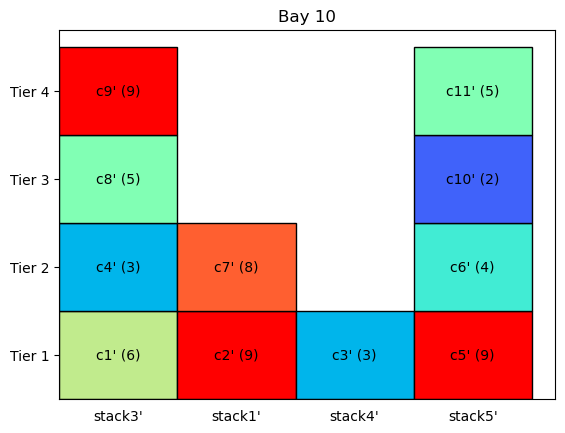

In [70]:
plot_bays(bays)

In [131]:
# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

def solve_all_bays(bays, α, λ1, λ2, H):
    all_moves = {}
    all_bays = {}

    # Loop over each bay in the dictionary
    for bay_num, bay in bays.items():
        print(f"*** Starting to solve bay {bay_num} ***")
        moves, new_bay = local_search_heuristic(bay, α, λ1, λ2, H)
        
        # Store the moves and the new bay configuration in the dictionaries
        all_moves[bay_num] = moves
        all_bays[bay_num] = new_bay

    return all_moves, all_bays

# α, λ1, λ2, and H are parameters of your heuristic, replace them with their actual values
all_moves, all_bays = solve_all_bays(bays, α, λ1, λ2, H)


*** Starting to solve bay 1 ***
Time Windows or Time Frames : 9
Containers in  9 time window : {"c12'", "c1'"}
####################
incorrectly_placed_containers   9 time window : ["c12'"]
Target Container in 9  time window : c12'
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [("c7'", 5), ("c11'", 2)], "stack2'": [("c13'", 8)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack5'": [("c8'", 7), ("c9'", 5)]}
bay:  {"stack1'": [("c7'", 5), ("c11'", 2)], "stack2'": [("c13'", 8)], "stack3'": [("c3'", 1), ("c5'", 8), ("c6'", 7), ("c10'", 4)], "stack4'": [("c1'", 9), ("c2'", 6), ("c4'", 7), ("c12'", 9)], "stack5'": [("c8'", 7), ("c9'", 5)]}
algorithm 3 is used
Set O_c: {}
Set M_c: {"c7'": 0, "c11'": 1}
available stack for relocation :  ["stack2'", "stack5'"]
lambda_2 selected stack for relocation :  ["stack5'", "stack2'"]
s_double_prime:  stack2'
available stack for relocation

ValueError: min() arg is an empty sequence

In [85]:
all_moves

{1: [("stack3'", "stack5'"),
  ("stack3'", "stack2'"),
  ("stack3'", "stack1'"),
  ("stack3'", "stack5'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack3'"),
  ("stack1'", "stack4'")],
 2: [("stack2'", "stack4'"),
  ("stack3'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack3'", "stack2'"),
  ("stack5'", "stack2'"),
  ("stack5'", "stack2'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack3'"),
  ("stack2'", "stack5'")],
 3: [("stack5'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack1'", "stack5'"),
  ("stack1'", "stack4'"),
  ("stack1'", "stack4'"),
  ("stack2'", "stack1'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack1'")],
 4: [("stack3'", "stack2'"),
  ("stack3'", "stack4'"),
  ("stack3'", "stack2'"),
  ("stack1'", "stack3'"),
  ("stack5'", "stack1'"

In [86]:
all_bays

{1: {"stack4'": [("c1'", 9), ("c5'", 8)],
  "stack3'": [("c12'", 9), ("c4'", 7), ("c2'", 6)],
  "stack1'": [("c7'", 5), ("c11'", 2)],
  "stack5'": [("c8'", 7), ("c9'", 5), ("c10'", 4), ("c3'", 1)],
  "stack2'": [("c13'", 8), ("c6'", 7)]},
 2: {"stack5'": [("c5'", 7)],
  "stack2'": [("c7'", 9), ("c8'", 7)],
  "stack3'": [("c3'", 7), ("c10'", 6), ("c6'", 3), ("c2'", 1)],
  "stack4'": [("c4'", 8), ("c9'", 6), ("c1'", 4)]},
 3: {"stack4'": [("c8'", 9), ("c9'", 6)],
  "stack5'": [("c2'", 3), ("c11'", 2)],
  "stack3'": [("c3'", 4), ("c1'", 1)],
  "stack1'": [("c4'", 9), ("c10'", 8), ("c7'", 6)],
  "stack2'": [("c5'", 7), ("c6'", 3)]},
 4: {"stack5'": [("c4'", 5)],
  "stack3'": [("c2'", 8), ("c6'", 6)],
  "stack2'": [("c3'", 9), ("c8'", 6), ("c9'", 5)],
  "stack1'": [("c5'", 4), ("c1'", 1)],
  "stack4'": [("c10'", 3), ("c7'", 1)]},
 5: {"stack1'": [("c1'", 9), ("c3'", 8)],
  "stack2'": [("c2'", 8)],
  "stack4'": [("c8'", 5), ("c6'", 2)],
  "stack3'": [("c5'", 8), ("c4'", 5), ("c7'", 2)],
  "s

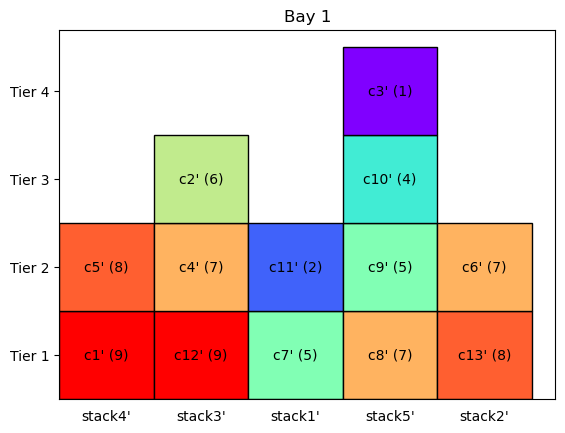

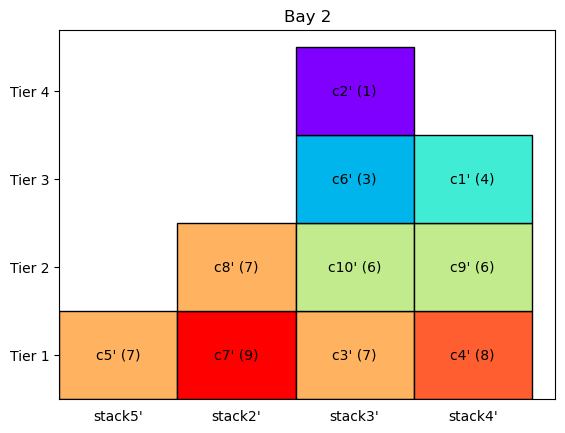

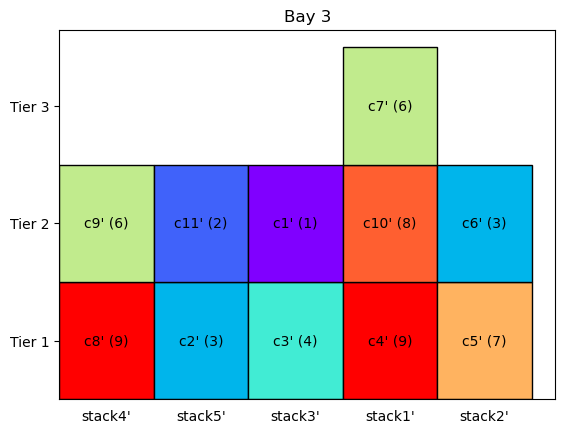

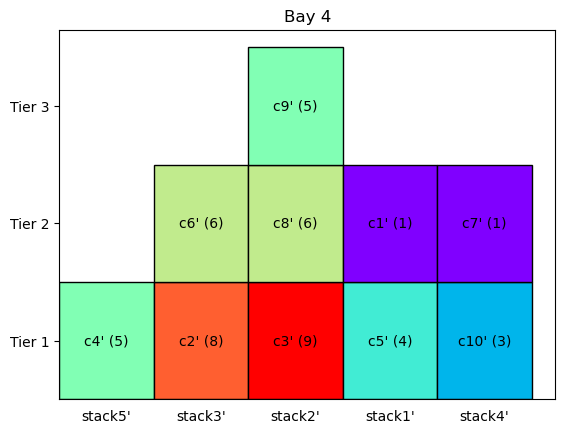

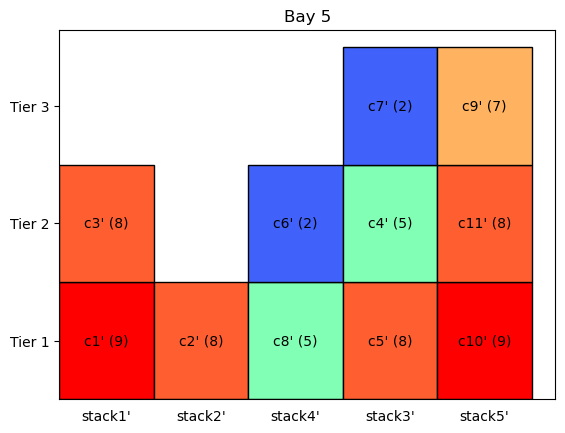

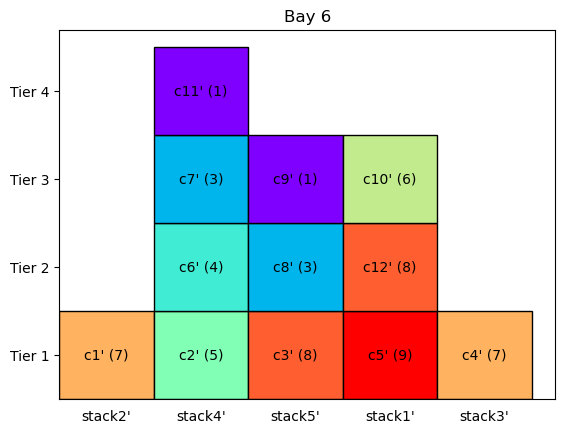

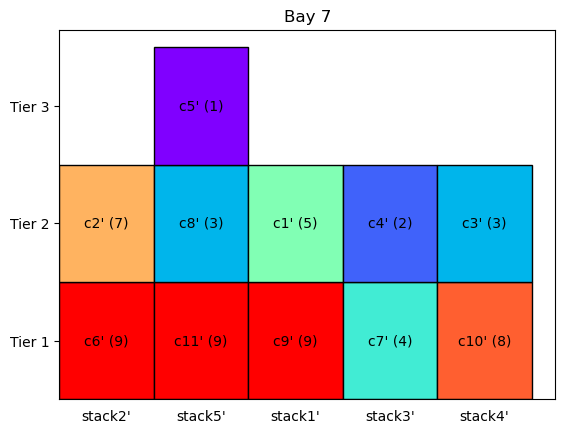

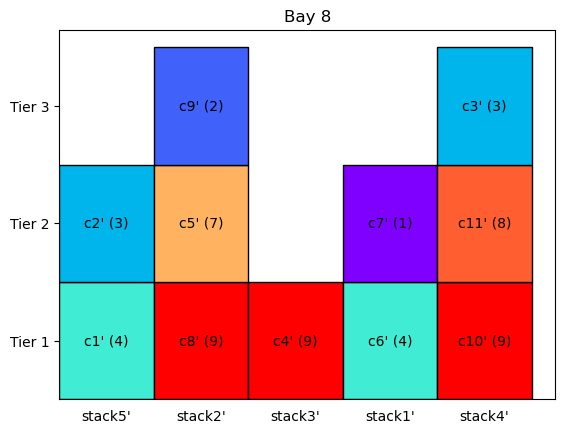

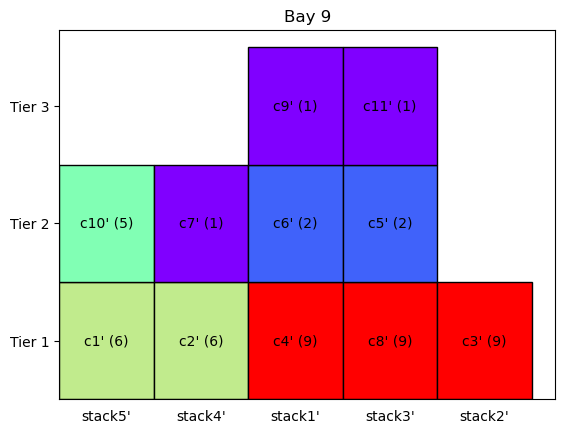

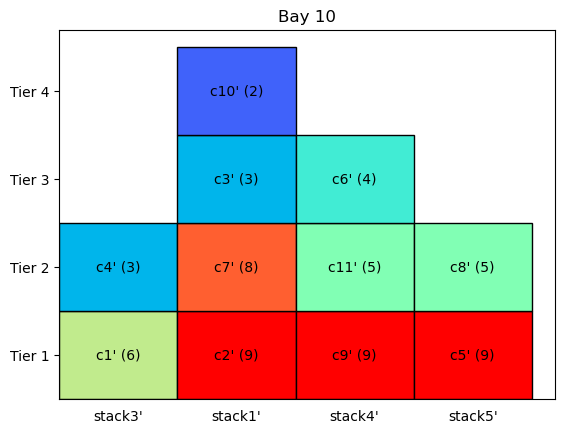

In [91]:
plot_bays(all_bays)

In [93]:
import pandas as pd

def export_to_excel(all_bays, file_name='bays.xlsx'):
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        for bay_id, bay in all_bays.items():
            # Convert each bay to a DataFrame
            df = pd.DataFrame.from_dict(bay, orient='index')

            # Write each DataFrame to a separate sheet in the Excel file
            df.to_excel(writer, sheet_name=f'Bay {bay_id}')

    print(f'Excel file saved as {file_name}')


In [95]:
export_to_excel(all_bays, 'updated_bays.xlsx')


Excel file saved as updated_bays.xlsx


In [96]:
import pandas as pd

def export_to_excel(all_bays, file_name='bays.xlsx'):
    data = []
    for bay_id, bay in all_bays.items():
        for stack_id, stack in bay.items():
            for tier, container_info in enumerate(stack, 1):  # Assuming tier starts from 1
                container_id, time_window = container_info
                data.append([bay_id, stack_id, tier, container_id, time_window])
    df = pd.DataFrame(data, columns=['Bay', 'Stack', 'Tier', 'Container', 'Time Window'])
    df.to_excel(file_name, index=False)
    print(f'Excel file saved as {file_name}')

export_to_excel(all_bays, 'updated_bays.xlsx')


Excel file saved as updated_bays.xlsx


In [99]:
all_moves

{1: [("stack3'", "stack5'"),
  ("stack3'", "stack2'"),
  ("stack3'", "stack1'"),
  ("stack3'", "stack5'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack3'"),
  ("stack1'", "stack4'")],
 2: [("stack2'", "stack4'"),
  ("stack3'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack3'", "stack2'"),
  ("stack5'", "stack2'"),
  ("stack5'", "stack2'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack3'"),
  ("stack2'", "stack5'")],
 3: [("stack5'", "stack2'"),
  ("stack4'", "stack3'"),
  ("stack5'", "stack4'"),
  ("stack2'", "stack4'"),
  ("stack1'", "stack5'"),
  ("stack1'", "stack4'"),
  ("stack1'", "stack4'"),
  ("stack2'", "stack1'"),
  ("stack4'", "stack2'"),
  ("stack4'", "stack1'")],
 4: [("stack3'", "stack2'"),
  ("stack3'", "stack4'"),
  ("stack3'", "stack2'"),
  ("stack1'", "stack3'"),
  ("stack5'", "stack1'"

In [101]:
import pandas as pd

def export_moves_to_excel(all_moves, file_name='moves.xlsx'):
    data = []
    for bay_id, moves in all_moves.items():
        for move in moves:
            source_stack, destination_stack = move
            data.append([bay_id, source_stack, destination_stack])
    df = pd.DataFrame(data, columns=['Bay', 'Source Stack', 'Destination Stack'])
    df.to_excel(file_name, index=False)
    print(f'Excel file saved as {file_name}')

export_moves_to_excel(all_moves, 'pre_processing_moves.xlsx')


Excel file saved as pre_processing_moves.xlsx


In [102]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, (stack_name, stack) in enumerate(bay.items()):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(bay)))
            ax.set_xticklabels(bay.keys())

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [103]:
plot_bays(bays, 'bays_plots.pdf')


In [104]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, (stack_name, stack) in enumerate(bay.items()):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(bay)))
            ax.set_xticklabels(bay.keys())

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f' Container Location in Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [118]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            # Ensure that all stacks are displayed
            for i in range(5):
                stack_name = f'stack{i+1}'
                if stack_name not in bay:
                    bay[stack_name] = []  # initialize an empty list for the stack

            for i, (stack_name, stack) in enumerate(sorted(bay.items())):
                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(5))  # there are 5 stacks
            ax.set_xticklabels([f'stack{i+1}' for i in range(5)])

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location for Bay {bay_num}')
            
            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [120]:
plot_bays(bays, 'initial_bays_plots1.pdf')

In [114]:
plot_bays_final(all_bays, 'final_bays_plots.pdf')

In [121]:
def plot_bays(bays, pdf_filename='bays_plots.pdf'):
    # Determine the total number of unique time windows
    unique_times = set()
    for bay in bays.values():
        for stack in bay.values():
            for container in stack:
                unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    # Define a fixed set of stack names
    stack_names = [f"stack{i}'" for i in range(1, 6)]

    with PdfPages(pdf_filename) as pdf:
        for bay_num, bay in bays.items():
            fig, ax = plt.subplots()

            for i, stack_name in enumerate(stack_names):
                stack = bay.get(stack_name, [])  # Use empty list if stack is not in the bay

                bottom = 0
                for j, (container_id, container_time) in enumerate(stack):
                    color_index = list(unique_times).index(container_time)
                    ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
                    ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                    bottom += 1

            ax.set_xticks(np.arange(len(stack_names)))
            ax.set_xticklabels(stack_names)

            ax.set_yticks(np.arange(max(len(stack) for stack in bay.values())) + 0.5)
            ax.set_yticklabels([f'Tier {i+1}' for i in range(max(len(stack) for stack in bay.values()))])

            plt.tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=True)

            ax.set_xlim(left=-0.5)
            plt.title(f'Initial Container Location for Bay {bay_num}')

            pdf.savefig(fig)  # save the current figure into the pdf file
            plt.close()  # close the figure to free up memory


In [122]:
plot_bays(bays, 'initial_bays_plots.pdf')

In [7]:
bay2={"stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [8]:
bay2

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [134]:
calculate_q_values(bay2)

{"stack1'": [],
 "stack2'": [1, 3],
 "stack3'": [1, 3, 1],
 "stack4'": [1],
 "stack5'": [1, 3, 3, 3]}

In [135]:
calculate_q_values(bay2)

{"stack1'": [],
 "stack2'": [1, 3],
 "stack3'": [1, 3, 1],
 "stack4'": [1],
 "stack5'": [1, 3, 3, 3]}

In [9]:
calculate_expected_relocation_moves(bay2)

5

In [16]:
calculate_expected_moves(bay2,"stack1'")

0

In [11]:
calculate_u_c(bay2,"c1'")

inf

In [17]:
def get_smallest_time_frame(stack):
    return min([c[1] for c in stack]) if stack else float('inf')


In [19]:
get_smallest_time_frame(bay2["stack1'"])

inf

In [477]:
def preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H):
    print("====================")
    print('algorithm 4 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    S1 = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    print('S1:', S1)
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c}
    #S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and not is_correctly_placed(bay, c[0])}
    S2 = {c[0]: index for index, c in enumerate(bay[s_c]) if index < p_c and calculate_u_c(bay, container_c) < t_c and get_container_time(bay,c[0])<t_c}

    print('S2:' ,S2)
    
    
    while S1:
        print('==for S1== ')
        c_prime = max(S1, key=S1.get) #top container
        print('c_prime: ',c_prime)
        t_c_prime = get_container_time(bay, c_prime) #get time of the container

        # Select s'' for relocation
        excluded_stacks=s_c
        s_double_prime = select_stack_for_relocation(bay_copy, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [],bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime]
        #bay_copy[s_c].pop()

        # Update pre-processing moves and S1
        P.append((s_c, s_double_prime))
        print('preprocessing moves: ',P)
        S1.pop(c_prime)
    
    print("==for c==")
    # Move container c to the highest stack s''' with n (s''') < H
    stack_triple_prime = select_stack_for_c(bay_copy, s_c, H)
    print('available stack for temporary relocation of,' ,container_c, ': ', stack_triple_prime)
    if stack_triple_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
        return [],bay
    bay_copy[stack_triple_prime].append((container_c, t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]  # remove container c from the stack
    #bay_copy[s-c].pop()
    P.append((s_c, stack_triple_prime))
    print('premoves after moving ,',container_c, ' : ',P)
    
    while S2:
        print('==for S2== ')
        c_prime = max(S2, key=S2.get)
        print('c_prime : ', c_prime)
        t_c_prime = get_container_time(bay, c_prime)
        # Select s'' for relocation
        excluded_stacks=[s_c,stack_triple_prime]
        s_double_prime = select_stack_for_relocation(bay_copy, excluded_stacks, c_prime, t_c_prime, α, λ1, λ2, H)
        
        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [],bay
        
        # Relocate container c' to stack s''
        bay_copy[s_double_prime].append((c_prime, t_c_prime))
        bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != c_prime]

        # Update pre-processing moves and S2
        P.append((s_c, s_double_prime))
        print('pre processing moves after moving ',c_prime, ' : ',P )
        S2.pop(c_prime)

    # Move container c to stack s
    bay_copy[s_c].append((container_c, t_c))
    bay_copy[stack_triple_prime] = [c for c in bay_copy[stack_triple_prime] if c[0] != container_c]
    P.append((stack_triple_prime, s_c))
    print("all preprocessing move : ", P)

    return P, bay_copy


# Define the bay
bay = {
    "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

# Define the container and stack
container_c = "c4'"
#stack_s = 'stack3'

# Define α, λ1, λ2, H
α = 0.75
λ1 = 1
λ2 = 1
H = 4

# Test Algorithm 4
P, updated_bay = preprocessing_moves_algo4(bay, container_c, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 4 is used
S1: {"c5'": 2, "c8'": 3}
S2: {"c1'": 0}
==for S1== 
c_prime:  c8'
candidate stacks:  ["stack1'", "stack2'", "stack3'", "stack4'"]
expected moves for  stack1' : 0
smallets time frame : inf
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack3' : 1
smallets time frame : 6
expected moves for  stack4' : 0
smallets time frame : 3
available stack from candidate stack wth get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]:  ["stack1'"]
selecting from  stacks with reloc moves < α 
available stack for relocation :  ["stack1'"]
lambda_2 selected stack for relocation :  ["stack1'"]
s_double_prime:  stack1'
preprocessing moves:  [("stack5'", "stack1'")]
==for S1== 
c_prime:  c5'
candidate stacks:  ["stack1'", "stack2'", "stack3'", "stack4'"]
expected moves for  stack1' : 0
smallets time frame : 7
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack3' : 1
smallets time frame : 6

In [470]:
bay


{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [471]:
updated_bay

{"stack1'": [("c8'", 7), ("c1'", 4)],
 "stack2'": [("c2'", 1), ("c9'", 6), ("c5'", 7)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c4'", 8)]}

In [472]:
P

[("stack5'", "stack1'"),
 ("stack5'", "stack2'"),
 ("stack5'", "stack2'"),
 ("stack5'", "stack1'"),
 ("stack2'", "stack5'")]

In [455]:
def preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H):
    print("====================")
    print('algorithm 3 is used')
    print("====================")
    P = []
    bay_copy=copy.deepcopy(bay)
    
    s_c, p_c = get_container_position(bay, container_c)  # Get original stack of c
    t_c = get_container_time(bay, container_c)

    O_c = {c[0]: index for index, c in enumerate(bay[s_c]) if index > p_c}
    #M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if calculate_u_c(bay, c[0]) < t_c}
    M_c = {c[0]: index for index, c in enumerate(bay[stack_s]) if (calculate_u_c(bay, c[0]) < t_c) or (get_container_time(bay,c[0]) < t_c)}

    print ('Set O_c:' ,O_c)
    print('Set M_c:', M_c)
    while O_c or M_c:
        o = max(O_c, key=O_c.get) if O_c else None
        m = max(M_c, key=M_c.get) if M_c else None
        
        if m is not None and (o is None or get_container_time(bay, m) >= get_container_time(bay, o)):
            print('get_container_time(bay, m) >= get_container_time(bay, o)')
            c_prime = m
            print('c_prime :',c_prime )
            M_c.pop(c_prime)
            p_1 = stack_s
            print('p_1: ',p_1)
        else:
            print('get_container_time(bay, m) < get_container_time(bay, o)')
            c_prime = o
            print('c_prime :',c_prime )
            O_c.pop(c_prime)
            p_1 = s_c
            print('p_1: ',p_1)

        t_c_prime = get_container_time(bay, c_prime)
        s_double_prime = select_stack_for_relocation(bay_copy, [s_c, stack_s], c_prime, t_c_prime, α, λ1, λ2, H)

        if s_double_prime is None:  # If there is no stack available for relocation
            #return P, None  # Return current pre-processing moves and None to indicate that the operation was not feasible
            return [], bay
        
        if s_double_prime is not None:
            print('Move non target container, ', c_prime, ',from stack, ' ,p_1, ' to ',s_double_prime )
            bay_copy[s_double_prime].append((c_prime, t_c_prime))
            bay_copy[p_1] = [c for c in bay_copy[p_1] if c[0] != c_prime]
            P.append((p_1, s_double_prime))
            print('pre-processing moves: ',P)

    # Move container c to the destination stack and update the bay
    print('move target container ',c, ' to destiantion stack ', stack_s)
    bay_copy[stack_s].append((container_c,t_c))
    bay_copy[s_c] = [c for c in bay_copy[s_c] if c[0] != container_c]
    P.append((s_c, stack_s))
    print('pre-processing moves after mvoing container c ;', P)

    return P, bay_copy
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }
# Define the container and destination stack
container_c = "c7'"
stack_s = "stack1'"

# Define α, λ1, λ2, H3
α = 0.75
λ1 = 1
λ2 = 1
H = 4

# Apply Algorithm 3
P, updated_bay = preprocessing_moves_algo3(bay, container_c, stack_s, α, λ1, λ2, H)
print("The pre-processing moves:", P)
print("The updated bay:", bay)


algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {}
get_container_time(bay, m) < get_container_time(bay, o)
c_prime : c10'
p_1:  stack3'
candidate stacks:  ["stack2'", "stack4'"]
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack4' : 0
smallets time frame : 3
available stack from candidate stack wth get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]:  []
alternative available stack from candidate stack:  ["stack2'", "stack4'"]
sortest stacks:  ["stack2'", "stack4'"]
selecting from stacks with len(stack) < H and stack_name not in exclude_stack
available stack for relocation :  ["stack2'", "stack4'"]
lambda_2 selected stack for relocation :  ["stack2'"]
s_double_prime:  stack2'
Move non target container,  c10' ,from stack,  stack3'  to  stack2'
pre-processing moves:  [("stack3'", "stack2'")]
move target container  c9'  to destiantion stack  stack1'
pre-processing moves after mvoing container c ; [("stack3'", "sta

In [131]:
bay

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [132]:
updated_bay

{"stack1'": [("c4'", 8)],
 "stack2'": [("c2'", 1), ("c9'", 6), ("c5'", 7)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6), ("c8'", 7)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4)]}

In [133]:
P

[("stack5'", "stack3'"), ("stack5'", "stack2'"), ("stack5'", "stack1'")]

In [104]:
def is_correctly_placed(bay, container_c):
    # Identify the current stack of the container c (s_c) and its position (p_c)
    s_c, p_c = get_container_position(bay, container_c)
    t_c = get_container_time(bay, container_c)  # get the time window of the container c

    # Get all the containers below c in stack s_c
    containers_below_c = get_containers_below(bay, container_c)

    # Check if all containers below c have a larger time frame
    for container in containers_below_c:
        if get_container_time(bay, container) <= t_c:
            return False  # c is incorrectly placed

    return True  # If all conditions are met, c is correctly placed

bay =  {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }
Z= max(time for stack in bay.values() for _, time in stack)

import random
for p in range(Z, 0, -1):
        # Get the containers with time frame p
        print(p)
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print(A_p)
        
        for _ in range(len(A_p)):
            # Create a list of all containers in A_p that are not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print('incorrectly placed :',incorrectly_placed_containers )
            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                print('selected incorrectly container:', c)


                A_p.remove(c)

9
{"c7'"}
incorrectly placed : ["c7'"]
selected incorrectly container: c7'
8
{"c4'"}
incorrectly placed : ["c4'"]
selected incorrectly container: c4'
7
{"c3'", "c8'", "c5'"}
incorrectly placed : ["c8'", "c5'"]
selected incorrectly container: c5'
incorrectly placed : ["c8'"]
selected incorrectly container: c8'
incorrectly placed : []
6
{"c9'", "c10'"}
incorrectly placed : ["c9'"]
selected incorrectly container: c9'
incorrectly placed : []
5
set()
4
{"c1'"}
incorrectly placed : []
3
{"c6'"}
incorrectly placed : []
2
set()
1
{"c2'"}
incorrectly placed : []


In [528]:
import copy
def local_search_heuristic(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    plot_bay(bay)
    #best_bay=copy.deepcopy(bay)
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get he containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)
            print('Excpected relocation with the current config: ', current_moves)
            best_improvement = 0
            best_stack = None
            #best_bay = None
            best_bay=copy.deepcopy(bay)
            best_moves = []

            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                # Create a copy of the current bay configuration
                #bay_copy = bay.copy()
                bay_copy = copy.deepcopy(bay)

                print('bay copy: ',bay_copy)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, updated_bay = preprocessing_moves_algo3(bay_copy, c, s, α, λ1, λ2, H)
                else:
                    pre_moves, updated_bay = preprocessing_moves_algo4(bay_copy, c, α, λ1, λ2, H)

                #if pre_moves is None or bay_copy is None:  # If the move was not feasible, skip to the next iteration
                if not pre_moves:  # If the move was not feasible, skip to the next iteration
                    continue
                    
                print('pre-moves for ',s,' stack :', pre_moves)
                print('new Bay orientation for ',s,' stack :', updated_bay)
                print('original Bay orientation for ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(updated_bay)
                m_s = len(pre_moves)
                #improvement = current_moves - (α * m_s + new_moves)
                
                print('Expected relocation moves: ', new_moves)
                improvement = current_moves -  new_moves
                print('improvement = current_moves -  new_moves: ', improvement)

                # Update the best improvement and the best destination stack
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_stack = s
                    best_bay = updated_bay
                    best_moves = pre_moves
                    print("*** improvement achieved***")
                    print("best moves: ", best_moves)
                    print("best bay :", updated_bay)
            # If the best improvement is positive, update the bay configuration and the pre-processing moves
            if best_improvement >= 0:
                bay = best_bay
                P += best_moves
                print('move to stack, ',best_stack,)
                print('pre-moves: ', best_moves)
                print('new bay: ',bay)
                plot_bay(best_bay)
    return P,bay




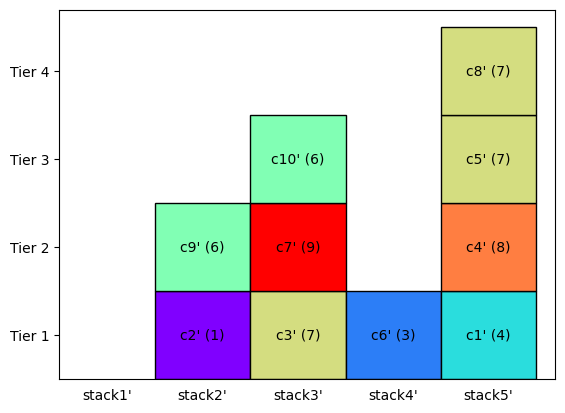

Time Windows or Time Frames : 9
Containers in  9 time window : {"c7'"}
####################
incorrectly_placed_containers   9 time window : ["c7'"]
Target Container in 9  time window : c7'
Excpected relocation with the current config:  5
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
bay:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {}
get_container_time(bay, m) < get_container_time(bay, o)
c_prime : c10'
p_1:  stack3'
candidate stacks:  ["stack2'", "stack4'"]
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack4' : 0
smallets time frame : 3
available stack

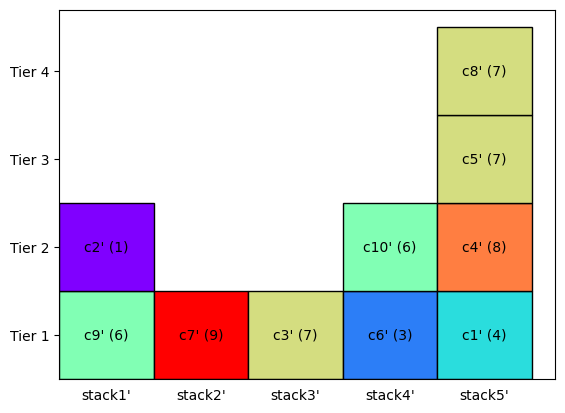

Containers in  8 time window : {"c4'"}
####################
incorrectly_placed_containers   8 time window : ["c4'"]
Target Container in 8  time window : c4'
Excpected relocation with the current config:  4
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [("c9'", 6), ("c2'", 1)], "stack2'": [("c7'", 9)], "stack3'": [("c3'", 7)], "stack4'": [("c6'", 3), ("c10'", 6)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
bay:  {"stack1'": [("c9'", 6), ("c2'", 1)], "stack2'": [("c7'", 9)], "stack3'": [("c3'", 7)], "stack4'": [("c6'", 3), ("c10'", 6)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
algorithm 3 is used
Set O_c: {"c5'": 2, "c8'": 3}
Set M_c: {"c9'": 0, "c2'": 1}
get_container_time(bay, m) < get_container_time(bay, o)
c_prime : c8'
p_1:  stack5'
candidate stacks:  ["stack2'", "stack3'", "stack4'"]
expected moves for  stack2' : 0
smallets time frame : 9
expected moves for  stack3' : 0
smallets time frame : 7
expected moves

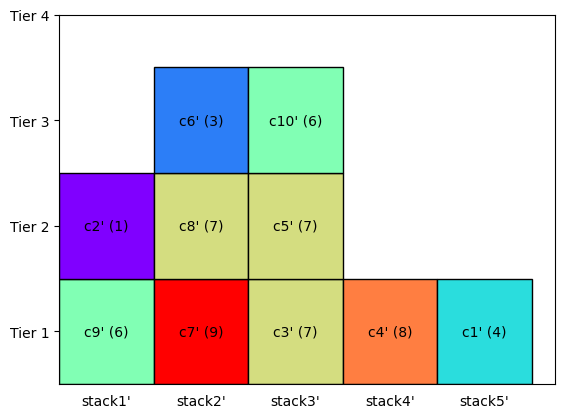

Containers in  7 time window : {"c3'", "c8'", "c5'"}
####################
incorrectly_placed_containers   7 time window : ["c5'"]
Target Container in 7  time window : c5'
Excpected relocation with the current config:  0.5
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [("c9'", 6), ("c2'", 1)], "stack2'": [("c7'", 9), ("c8'", 7), ("c6'", 3)], "stack3'": [("c3'", 7), ("c5'", 7), ("c10'", 6)], "stack4'": [("c4'", 8)], "stack5'": [("c1'", 4)]}
bay:  {"stack1'": [("c9'", 6), ("c2'", 1)], "stack2'": [("c7'", 9), ("c8'", 7), ("c6'", 3)], "stack3'": [("c3'", 7), ("c5'", 7), ("c10'", 6)], "stack4'": [("c4'", 8)], "stack5'": [("c1'", 4)]}
algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {"c9'": 0, "c2'": 1}
get_container_time(bay, m) < get_container_time(bay, o)
c_prime : c10'
p_1:  stack3'
candidate stacks:  ["stack2'", "stack4'", "stack5'"]
expected moves for  stack2' : 0
smallets time frame : 3
expected moves for  stack4' : 0
smallets time frame : 8
expect

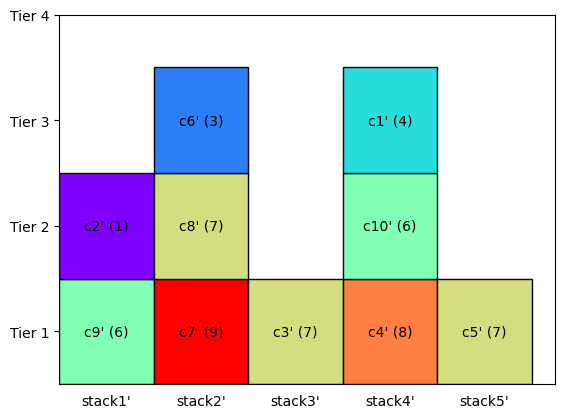

####################
incorrectly_placed_containers   7 time window : []
Containers in  6 time window : {"c9'", "c10'"}
####################
incorrectly_placed_containers   6 time window : []
Containers in  5 time window : set()
Containers in  4 time window : {"c1'"}
####################
incorrectly_placed_containers   4 time window : []
Containers in  3 time window : {"c6'"}
####################
incorrectly_placed_containers   3 time window : []
Containers in  2 time window : set()
Containers in  1 time window : {"c2'"}
####################
incorrectly_placed_containers   1 time window : []
The pre-processing moves: [("stack2'", "stack1'"), ("stack3'", "stack4'"), ("stack2'", "stack1'"), ("stack3'", "stack2'"), ("stack5'", "stack2'"), ("stack5'", "stack3'"), ("stack4'", "stack3'"), ("stack4'", "stack2'"), ("stack5'", "stack4'"), ("stack3'", "stack4'"), ("stack5'", "stack4'"), ("stack3'", "stack5'")]
The updated bay: {"stack1'": [("c9'", 6), ("c2'", 1)], "stack2'": [("c7'", 9), ("c8'", 

In [541]:
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

In [542]:
bay

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [543]:
P

[("stack2'", "stack1'"),
 ("stack3'", "stack4'"),
 ("stack2'", "stack1'"),
 ("stack3'", "stack2'"),
 ("stack5'", "stack2'"),
 ("stack5'", "stack3'"),
 ("stack4'", "stack3'"),
 ("stack4'", "stack2'"),
 ("stack5'", "stack4'"),
 ("stack3'", "stack4'"),
 ("stack5'", "stack4'"),
 ("stack3'", "stack5'")]

In [544]:
updated_bay

{"stack1'": [("c9'", 6), ("c2'", 1)],
 "stack2'": [("c7'", 9), ("c8'", 7), ("c6'", 3)],
 "stack3'": [("c3'", 7)],
 "stack4'": [("c4'", 8), ("c10'", 6), ("c1'", 4)],
 "stack5'": [("c5'", 7)]}

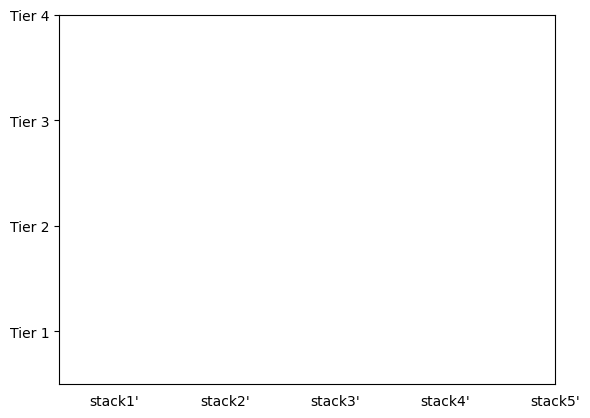

Time Windows or Time Frames : 5
Containers in  5 time window : {'c4', 'c5', 'c10'}
####################
incorrectly_placed_containers   5 time window : ['c4', 'c10']
Target Container in 5  time window : c10
Excpected relocation with the current config:  6.199999999999999
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
bay:  {'stack1': [('c1', 4), ('c2', 4)], 'stack2': [('c3', 1), ('c4', 5)], 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)], 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)], 'stack5': [('c12', 3), ('c13', 2)]}
algorithm 3 is used
Set O_c: {'c11': 2}
Set M_c: {'c1': 0, 'c2': 1}
get_container_time(bay, m) >= get_container_time(bay, o)
c_prime : c2
p_1:  stack1
candidate stacks:  ['stack2', 'stack5']
expected moves for  stack2 : 1.4
smallets tim

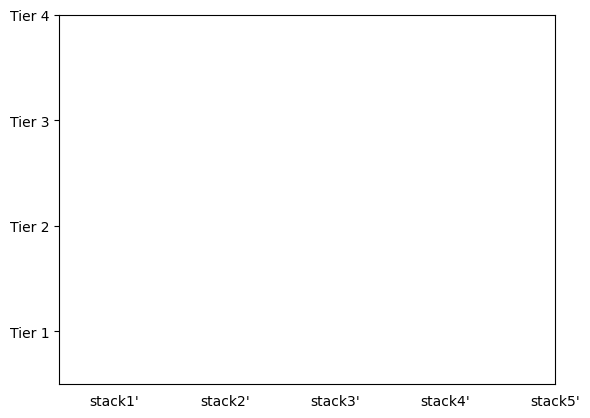

####################
incorrectly_placed_containers   5 time window : ['c4']
Target Container in 5  time window : c4
Excpected relocation with the current config:  3.9
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c3', 1), ('c4', 5), ('c6', 1)], 'stack3': [('c5', 5), ('c10', 5)], 'stack4': [('c9', 2)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
bay:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c3', 1), ('c4', 5), ('c6', 1)], 'stack3': [('c5', 5), ('c10', 5)], 'stack4': [('c9', 2)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
algorithm 3 is used
Set O_c: {'c6': 2}
Set M_c: {'c1': 0, 'c2': 1, 'c11': 2, 'c8': 3}
get_container_time(bay, m) >= get_container_time(bay, o)
c_prime : c8
p_1:  stack1
candidate stacks:  ['stack3', 'stack4', 'stack5']
expected moves for  stack3 : 0.5
smallets time frame : 5
expected moves for  stack4 : 0
smallets time frame : 2
expected m

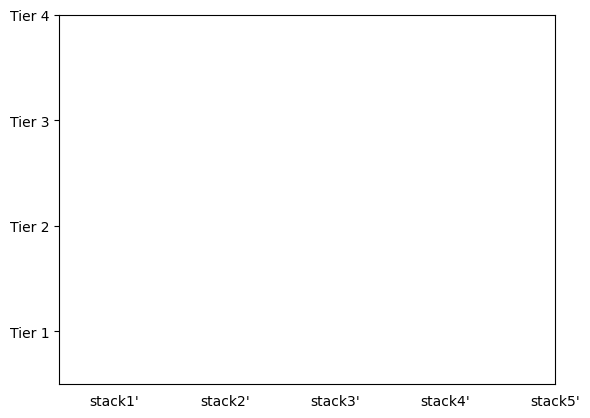

####################
incorrectly_placed_containers   5 time window : []
Containers in  4 time window : {'c1', 'c2', 'c7'}
####################
incorrectly_placed_containers   4 time window : ['c2', 'c7']
Target Container in 4  time window : c2
Excpected relocation with the current config:  2.0
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)], 'stack4': [('c9', 2), ('c3', 1)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
bay:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)], 'stack4': [('c9', 2), ('c3', 1)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
algorithm 4 is used
S1: {'c11': 2, 'c8': 3}
S2: {}
==for S1== 
c_prime:  c8
candidate stacks:  ['stack2', 'stack3', 'stack4', 'stack5']
expected moves for  stack2 : 0
smallets time frame : 5
expected moves for  st

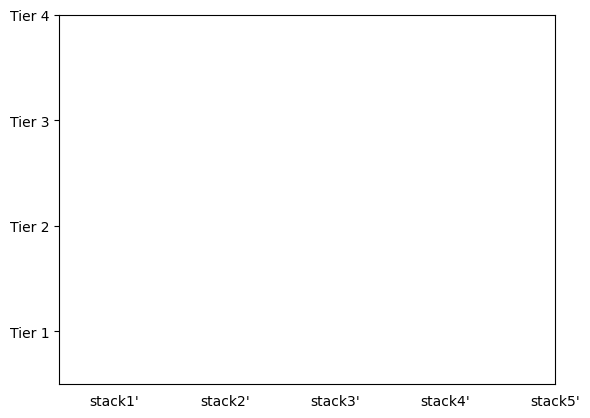

####################
incorrectly_placed_containers   4 time window : ['c7']
Target Container in 4  time window : c7
Excpected relocation with the current config:  2.0
___________________________________
checkin stack : stack1
bay copy:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)], 'stack4': [('c9', 2), ('c3', 1)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
bay:  {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c4', 5)], 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)], 'stack4': [('c9', 2), ('c3', 1)], 'stack5': [('c12', 3), ('c13', 2), ('c7', 4)]}
algorithm 3 is used
Set O_c: {}
Set M_c: {'c11': 2, 'c8': 3}
get_container_time(bay, m) >= get_container_time(bay, o)
c_prime : c8
p_1:  stack1
candidate stacks:  ['stack2', 'stack3', 'stack4']
expected moves for  stack2 : 0
smallets time frame : 5
expected moves for  stack3 : 0.5
smallets time frame : 1
expected moves for  stack4 : 0
smal

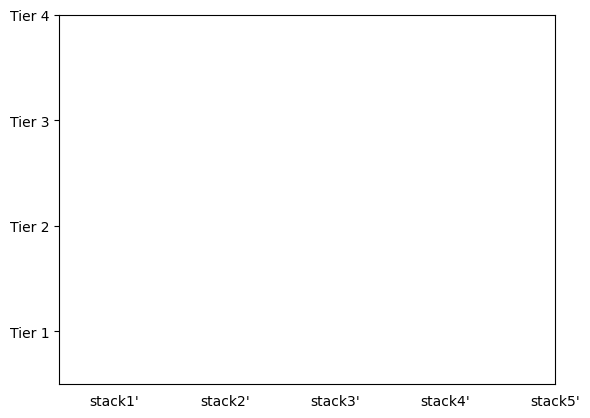

####################
incorrectly_placed_containers   4 time window : []
Containers in  3 time window : {'c11', 'c12'}
####################
incorrectly_placed_containers   3 time window : []
Containers in  2 time window : {'c13', 'c9'}
####################
incorrectly_placed_containers   2 time window : []
Containers in  1 time window : {'c8', 'c6', 'c3'}
####################
incorrectly_placed_containers   1 time window : []
The pre-processing moves: [('stack4', 'stack1'), ('stack3', 'stack1'), ('stack3', 'stack5'), ('stack3', 'stack2'), ('stack4', 'stack3'), ('stack2', 'stack3'), ('stack2', 'stack3'), ('stack2', 'stack4'), ('stack3', 'stack2'), ('stack5', 'stack2')]
The updated bay: {'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)], 'stack2': [('c4', 5), ('c7', 4)], 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)], 'stack4': [('c9', 2), ('c3', 1)], 'stack5': [('c12', 3), ('c13', 2)]}


In [537]:
# Define the bay
bay = {
    "stack1": [('c1', 4), ('c2', 4)],
    "stack2": [('c3', 1), ('c4', 5)],
    "stack3": [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
    "stack4": [('c9', 2), ('c10', 5), ('c11', 3)],
    "stack5": [('c12', 3), ('c13', 2)]
}

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 3
λ2 = 3
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

In [538]:
bay

{'stack1': [('c1', 4), ('c2', 4)],
 'stack2': [('c3', 1), ('c4', 5)],
 'stack3': [('c5', 5), ('c6', 1), ('c7', 4), ('c8', 1)],
 'stack4': [('c9', 2), ('c10', 5), ('c11', 3)],
 'stack5': [('c12', 3), ('c13', 2)]}

In [539]:
updated_bay

{'stack1': [('c1', 4), ('c2', 4), ('c11', 3), ('c8', 1)],
 'stack2': [('c4', 5), ('c7', 4)],
 'stack3': [('c5', 5), ('c10', 5), ('c6', 1)],
 'stack4': [('c9', 2), ('c3', 1)],
 'stack5': [('c12', 3), ('c13', 2)]}

In [540]:
P

[('stack4', 'stack1'),
 ('stack3', 'stack1'),
 ('stack3', 'stack5'),
 ('stack3', 'stack2'),
 ('stack4', 'stack3'),
 ('stack2', 'stack3'),
 ('stack2', 'stack3'),
 ('stack2', 'stack4'),
 ('stack3', 'stack2'),
 ('stack5', 'stack2')]

In [420]:
#corrrected trial

def local_search_heuristic2(bay, α, λ1, λ2, H):
    # Initialize pre-processing moves
    P = []
    # Determine the maximum time frame Z
    Z = max(time for stack in bay.values() for _, time in stack)
    print('Time Windows or Time Frames :', Z)
    # Start with the largest time frame
    for p in range(Z, 0, -1):
        # Get he containers with time frame p
        A_p = {c for stack in bay.values() for c, t in stack if t == p}
        print('Containers in ', p, 'time window :', A_p )
        while A_p:
            # Select randomly a container c with time frame p that is not correctly placed
            incorrectly_placed_containers = [container for container in A_p if not is_correctly_placed(bay, container)]
            print("####################")
            print('incorrectly_placed_containers  ', p, 'time window :', incorrectly_placed_containers)

            if incorrectly_placed_containers:  # Check if the list is not empty
                c = random.choice(incorrectly_placed_containers)
                A_p.remove(c)
            else:
                break  # Exit the while loop if no incorrectly placed containers are found

            # Calculate the expected number of moves in the current bay configuration
            print("Target Container in",p," time window :", c)
            current_moves = calculate_expected_relocation_moves(bay)
            print('Excpected relocation with the current config: ', current_moves)
            # Consider each stack as a potential destination for the container c
            for s in bay:
                # Skip if the current stack is the same as the destination stack
                print("___________________________________")
                print('checkin stack :',s)
                print('bay: ',bay)

                # Attempt to move container c to stack s
                if s != get_container_position(bay, c)[0]:  # If destination stack is not the same as the original
                    pre_moves, new_bay = preprocessing_moves_algo3(copy.deepcopy(bay), c, s, α, λ1, λ2, H)
                else:
                    pre_moves, new_bay = preprocessing_moves_algo4(copy.deepcopy(bay), c, α, λ1, λ2, H)

                if not pre_moves:  # If the move was not feasible, skip to the next iteration
                    continue
                    
                print('pre-moves for considering',s,' stack :', pre_moves)
                print('new Bay orientation considering moving to ',s,' stack :', new_bay)
                print('original Bay orientation before moving to ',s,' stack :', bay)
                # Calculate the improvement
                new_moves = calculate_expected_relocation_moves(new_bay)
                print('Expected relocation moves: ', new_moves)
                improvement = current_moves -  new_moves
                print('improvement = current_moves -  new_moves: ', improvement)
                
            # If the improvement is positive or zero, update the bay configuration and the pre-processing moves
            if improvement >= 0:
                bay = new_bay
                P += pre_moves
                break

    return P,bay


In [440]:
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 1
λ2 = 1
H = 4

# Apply the local search heuristic (Algorithm 2)
P,updated_bay = local_search_heuristic2(bay, α, λ1, λ2, H)


print("The pre-processing moves:", P)
print("The updated bay:", updated_bay)

Time Windows or Time Frames : 9
Containers in  9 time window : {"c7'"}
####################
incorrectly_placed_containers   9 time window : ["c7'"]
Target Container in 9  time window : c7'
Excpected relocation with the current config:  5
___________________________________
checkin stack : stack1'
bay:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {}
candidate stacks:  ["stack2'", "stack4'"]
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack4' : 0
smallets time frame : 3
available stack from candidate stack wth get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]:  []
alternative available stack from candidate stack:  ["stack2'", "stack4'"]
sortest stacks:  ["stack2'", "stack4'"]
selecting from stacks with len(stack) < H and

In [545]:
bay

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [546]:
updated_bay

{"stack1'": [("c9'", 6), ("c2'", 1)],
 "stack2'": [("c7'", 9), ("c8'", 7), ("c6'", 3)],
 "stack3'": [("c3'", 7)],
 "stack4'": [("c4'", 8), ("c10'", 6), ("c1'", 4)],
 "stack5'": [("c5'", 7)]}

In [547]:
P

[("stack2'", "stack1'"),
 ("stack3'", "stack4'"),
 ("stack2'", "stack1'"),
 ("stack3'", "stack2'"),
 ("stack5'", "stack2'"),
 ("stack5'", "stack3'"),
 ("stack4'", "stack3'"),
 ("stack4'", "stack2'"),
 ("stack5'", "stack4'"),
 ("stack3'", "stack4'"),
 ("stack5'", "stack4'"),
 ("stack3'", "stack5'")]

In [426]:
P,updated_bay = local_search_heuristic(bay, α, λ1, λ2, H)


Time Windows or Time Frames : 9
Containers in  9 time window : {"c7'"}
####################
incorrectly_placed_containers   9 time window : ["c7'"]
Target Container in 9  time window : c7'
___________________________________
checkin stack : stack1'
bay copy:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
bay:  {"stack1'": [], "stack2'": [("c2'", 1), ("c9'", 6)], "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)], "stack4'": [("c6'", 3)], "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}
algorithm 3 is used
Set O_c: {"c10'": 2}
Set M_c: {}
all stacks:  ["stack1'", "stack2'", "stack3'", "stack4'"]
candidate stacks:  ["stack2'", "stack4'"]
expected moves for  stack2' : 1
smallets time frame : 1
expected moves for  stack4' : 0
smallets time frame : 3
available stack from candidate stack wth get_smallest_time_frame(stack) > t_c_prime and cal

In [427]:
updated_bay

{"stack1'": [("c8'", 7), ("c10'", 6)],
 "stack2'": [("c4'", 8), ("c5'", 7)],
 "stack3'": [("c3'", 7), ("c9'", 6), ("c1'", 4)],
 "stack4'": [("c6'", 3), ("c2'", 1)],
 "stack5'": [("c7'", 9)]}

In [428]:
P

[("stack5'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack3'", "stack1'"),
 ("stack5'", "stack1'"),
 ("stack3'", "stack5'"),
 ("stack2'", "stack3'"),
 ("stack1'", "stack3'"),
 ("stack1'", "stack3'"),
 ("stack2'", "stack4'"),
 ("stack1'", "stack2'"),
 ("stack1'", "stack2'"),
 ("stack3'", "stack1'")]

In [517]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_bay(bay, max_stacks=5, max_tiers=4):
    fig, ax = plt.subplots()

    # Determine the total number of unique time windows
    unique_times = set()
    for stack in bay.values():
        for container in stack:
            unique_times.add(container[1])
    num_unique_times = len(unique_times)

    # Generate a color for each unique time window
    colors = cm.rainbow(np.linspace(0, 1, num_unique_times))

    for i in range(max_stacks):  # loop over max_stacks, not bay.items()
        stack_name = f'stack{i+1}\''  # generate the stack_name including the apostrophe
        stack = bay.get(stack_name, [])  # use get() method to avoid KeyError
        bottom = 0
        for j, (container_id, container_time) in enumerate(stack):
            color_index = list(unique_times).index(container_time)
            ax.bar(i, 1, bottom=bottom, color=colors[color_index], edgecolor='black', width=1)
            ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
            bottom += 1

    ax.set_xticks(np.arange(max_stacks))  # set xticks to max_stacks
    ax.set_xticklabels([f'stack{i+1}\'' for i in range(max_stacks)])  # set xticklabels accordingly

    ax.set_yticks(np.arange(max_tiers) + 0.5)  # set yticks to max_tiers
    ax.set_yticklabels([f'Tier {i+1}' for i in range(max_tiers)])  # set yticklabels accordingly

    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,        
        labelbottom=True)

    ax.set_xlim(left=-0.5)
    plt.show()


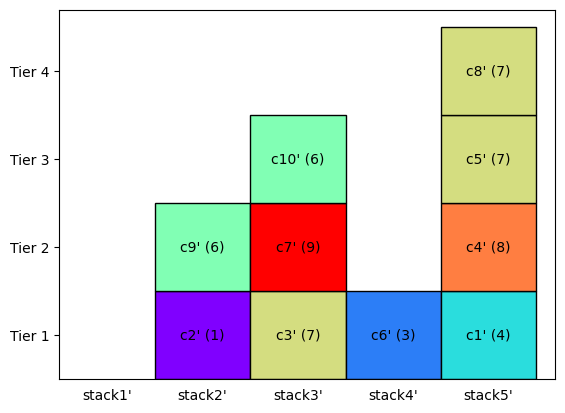

In [382]:
plot_bay(bay)

In [380]:
bay

{"stack1'": [],
 "stack2'": [("c2'", 1), ("c9'", 6)],
 "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
 "stack4'": [("c6'", 3)],
 "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]}

In [ ]:
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

# Define α, λ1, λ2, and H
α = 0.75
λ1 = 1
λ2 = 1
H = 4

In [ ]:
select_stack_for_relocation(bay, "stack3'",)

In [439]:
def select_stack_for_relocation(bay, exclude_stacks, c_prime, t_c_prime, α, λ1, λ2, H):
    # If there exists a stack s' in S \ exclude_stacks for which n(s') < H and l(s') > t(c') and f(B, s') <= α
    
    
    #all_stacks=[stack_name for stack_name, stack in bay.items() if len(stack)<H ]
    #print('all stacks: ', all_stacks)
    candidate_stacks=[stack_name for stack_name, stack in bay.items() if len(stack)<H and stack_name not in exclude_stacks]
    print("candidate stacks: ", candidate_stacks)
    for cs in candidate_stacks:
        print('expected moves for ',cs ,':', calculate_expected_moves(bay,cs))
        print('smallets time frame :',get_smallest_time_frame(bay[cs]))
    available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks and get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]
    print('available stack from candidate stack wth get_smallest_time_frame(stack) > t_c_prime and calculate_expected_moves(bay, stack_name) <= α]: ', available_stacks)
    if available_stacks:
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        # Select λ1 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ1]
        print('selecting from  stacks with reloc moves < α ')
    else:
        # If no valid stacks, select one with the smallest minimum time frame
        available_stacks = [stack_name for stack_name, stack in bay.items() if len(stack) < H and stack_name not in exclude_stacks]
        
        print('alternative available stack from candidate stack: ', available_stacks)
        # Sort the stacks by the smallest minimum time frame
        sorted_stacks = sorted(available_stacks, key=lambda k: get_smallest_time_frame(bay[k]))
        print('sortest stacks: ', sorted_stacks)
        # Select λ2 stacks with the smallest minimum time frame
        selected_stacks = sorted_stacks[:λ2]
        print('selecting from stacks with len(stack) < H and stack_name not in exclude_stack')
    # Select a stack randomly
    if selected_stacks:  # Check if the list is not empty
        s_double_prime = random.choice(selected_stacks)
    else:
        s_double_prime = None
    print('available stack for relocation : ', available_stacks)
    
    print('lambda_2 selected stack for relocation : ',selected_stacks)
    print('s_double_prime: ', s_double_prime)
    return s_double_prime

def select_stack_for_c(bay, s_c, H):
    # Find the available stacks for moving container c
    available_stacks = [s for s in bay.keys() if s != s_c and len(bay[s]) < H]
    
    # If no stacks are available, return None
    if not available_stacks:
        return None

    # Find the stack with the highest number of containers
    highest_stack = max(available_stacks, key=lambda s: len(bay[s]))
    print('available stack for c : ', available_stacks)
    print('highest stack for c : ',highest_stack)
    return highest_stack

In [397]:
calculate_q_values(bay)

{"stack1'": [],
 "stack2'": [1, 3],
 "stack3'": [1, 3, 1],
 "stack4'": [1],
 "stack5'": [1, 3, 3, 3]}

In [402]:
get_smallest_time_frame([("c2'", 1), ("c9'", 6)])

1

In [560]:
def plot_bay_moves(bay, move=None):
    fig, ax = plt.subplots()

    # Use unique color for each unique time window
    unique_times = set(container[1] for stack in bay.values() for container in stack)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_times)))

    # add hatch patterns
    hatch_patterns = ['', '/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

    for i, (stack_name, stack) in enumerate(bay.items()):
        bottom = 0
        for j, (container_id, container_time) in enumerate(stack):
            # get color
            color_index = list(unique_times).index(container_time)
            color = colors[color_index]
            
            hatch = None
            if move is not None:
                if stack_name == move[0] and j == len(stack) - 1: # Source stack and top container
                    hatch = hatch_patterns[1] # You can select different hatch patterns
                elif stack_name == move[1] and j == len(stack) - 1: # Destination stack and top container
                    hatch = hatch_patterns[2] # Different hatch pattern
                
            ax.bar(i, 1, bottom=bottom, color=color, edgecolor='black', width=1, hatch=hatch)
            ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
            bottom += 1

    ax.set_xticks(np.arange(len(bay)))
    ax.set_xticklabels(bay.keys())
    ax.set_yticks(np.arange(4) + 0.5)
    ax.set_yticklabels([f'Tier {i+1}' for i in range(4)])

    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=True)

    ax.set_xlim(left=-0.5)

    if move is not None:
        plt.title(f'Move: {move[0]} to {move[1]}')
    else:
        plt.title('Initial Container Location')

    plt.show()


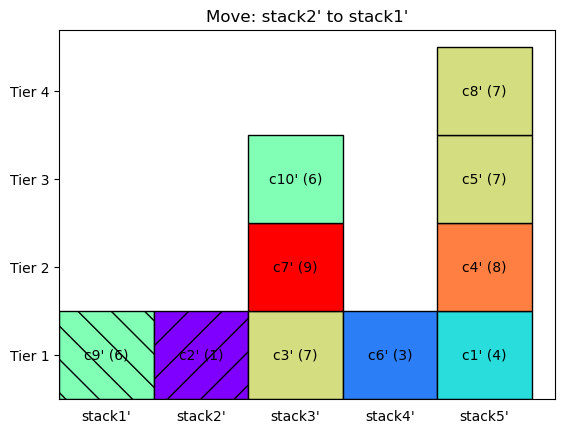

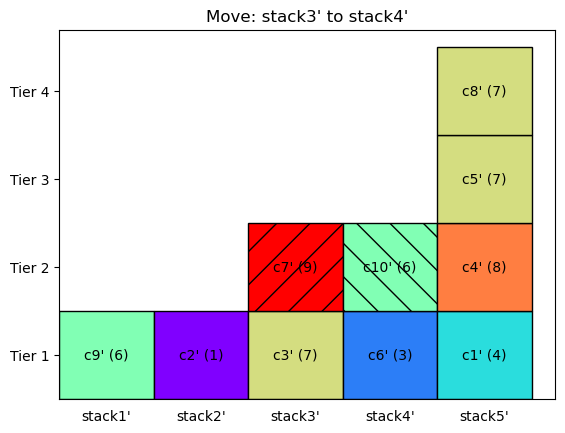

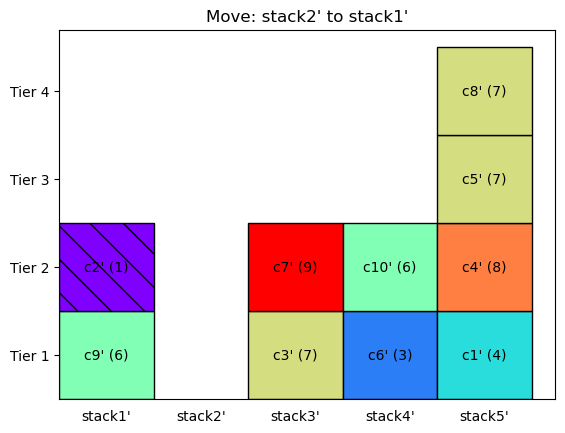

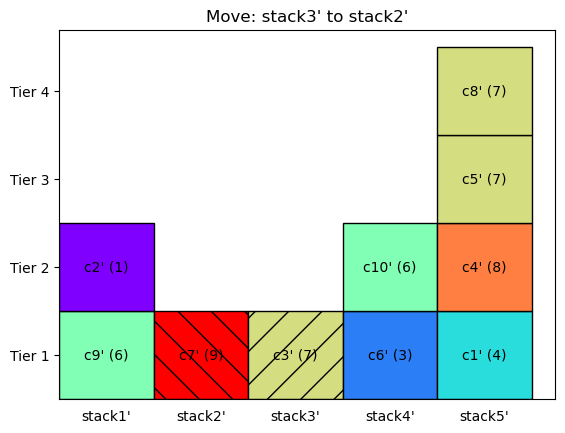

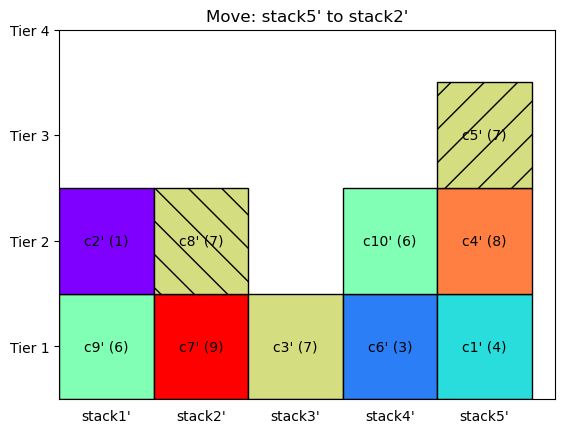

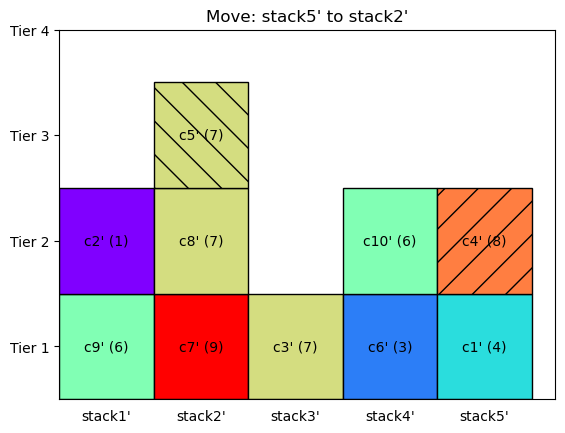

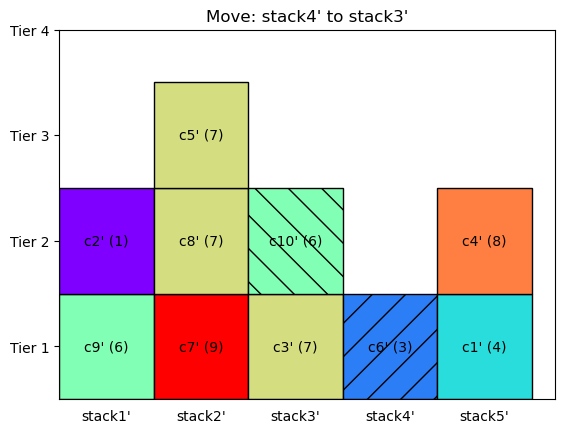

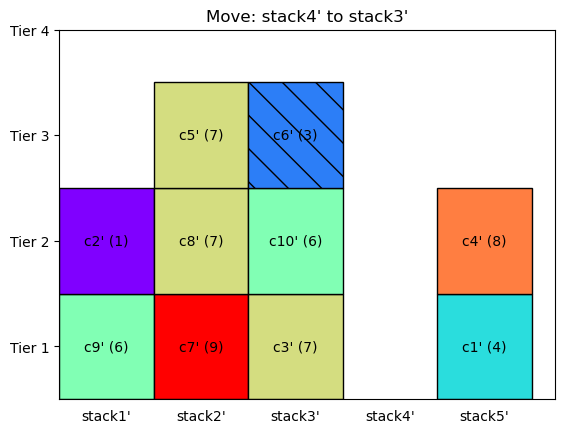

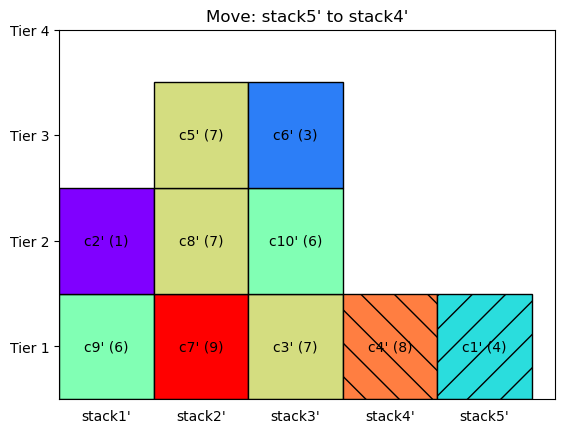

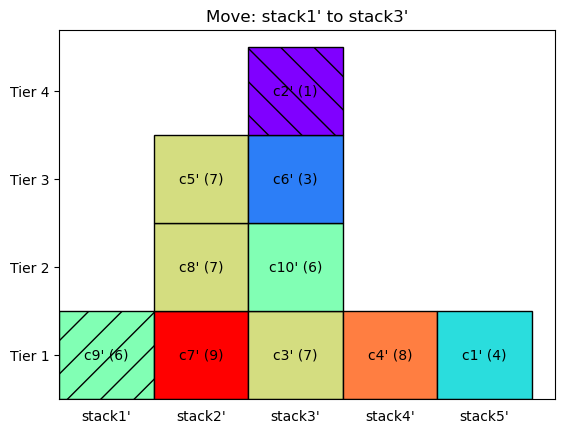

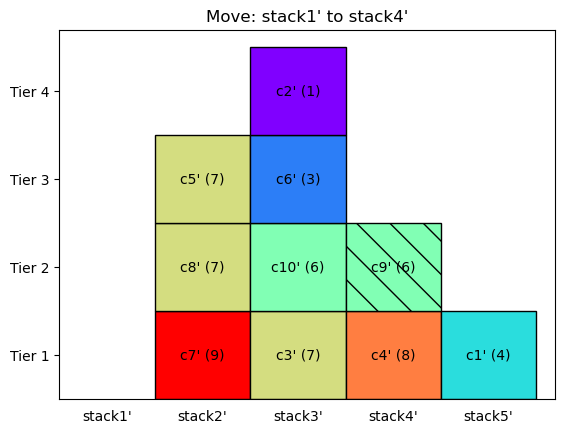

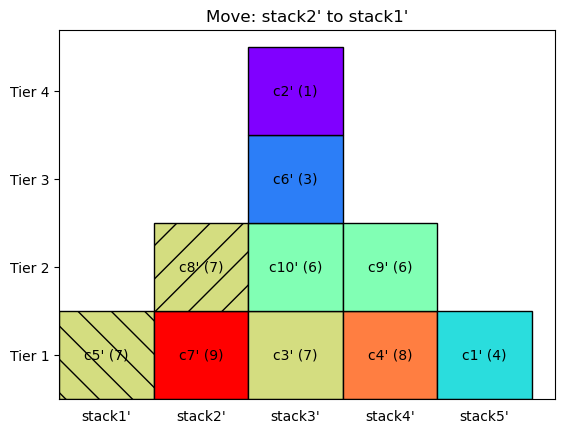

In [535]:
# Define the bay
bay = {
     "stack1'": [],
  "stack2'": [("c2'", 1), ("c9'", 6)],
  "stack3'": [("c3'", 7), ("c7'", 9), ("c10'", 6)],
  "stack4'": [("c6'", 3)],
  "stack5'": [("c1'", 4), ("c4'", 8), ("c5'", 7), ("c8'", 7)]
      }

P=[("stack2'", "stack1'"),
 ("stack3'", "stack4'"),
 ("stack2'", "stack1'"),
 ("stack3'", "stack2'"),
 ("stack5'", "stack2'"),
 ("stack5'", "stack2'"),
 ("stack4'", "stack3'"),
 ("stack4'", "stack3'"),
 ("stack5'", "stack4'"),
 ("stack1'", "stack3'"),
 ("stack1'", "stack4'"),
 ("stack2'", "stack1'")]

for move in P:
    # Perform the move
    container = bay[move[0]].pop()
    bay[move[1]].append(container)
    # Visualize the bay after the move
    plot_bay_moves(bay, move)


In [536]:
def plot_bay(bay, move=None, move_applied=False):
    fig, ax = plt.subplots()

    # Use unique color for each unique time window
    unique_times = set(container[1] for stack in bay.values() for container in stack)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_times)))

    # add hatch patterns
    hatch_patterns = ['', '/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

    for i, (stack_name, stack) in enumerate(bay.items()):
        bottom = 0
        for j, (container_id, container_time) in enumerate(stack):
            # get color
            color_index = list(unique_times).index(container_time)
            color = colors[color_index]
            
            hatch = None
            if move is not None:
                if stack_name == move[0] and j == len(stack) - 1 and not move_applied: # Source stack and top container before move
                    hatch = hatch_patterns[1] # You can select different hatch patterns
                elif stack_name == move[1] and j == len(stack) - 1 and move_applied: # Destination stack and top container after move
                    hatch = hatch_patterns[2] # Different hatch pattern
                
            ax.bar(i, 1, bottom=bottom, color=color, edgecolor='black', width=1, hatch=hatch)
            ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
            bottom += 1

    ax.set_xticks(np.arange(len(bay)))
    ax.set_xticklabels(bay.keys())
    ax.set_yticks(np.arange(4) + 0.5)
    ax.set_yticklabels([f'Tier {i+1}' for i in range(4)])

    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=True)

    ax.set_xlim(left=-0.5)

    if move is not None:
        if not move_applied:
            plt.title(f'Before Move: {move[0]} to {move[1]}')
        else:
            plt.title(f'After Move: {move[0]} to {move[1]}')
    else:
        plt.title('Initial Container Location')

    plt.show()

P=[("stack2'", "stack1'"),
   ("stack3'", "stack4'"),
   # add more moves here...
]

for move in P:
    # Visualize the bay before the move
    plot_bay(bay, move, move_applied=False)
    
    # Perform the move
    container = bay[move[0]].pop()
    bay[move[1]].append(container)
    
    # Visualize the bay after the move
    plot_bay(bay, move, move_applied=True)


TypeError: plot_bay() got an unexpected keyword argument 'move_applied'

In [563]:
def plot_bay_with_moves(bay, moves, max_stacks=5, max_tiers=4):
    for idx, move in enumerate(moves):
        # Perform the move
        source_stack, target_stack = move
        source_container = bay[source_stack].pop()
        bay[target_stack].append(source_container)
        
        # Create a plot
        fig, ax = plt.subplots()

        # Color map setup
        unique_times = set(container[1] for stack in bay.values() for container in stack)
        colors = cm.rainbow(np.linspace(0, 1, len(unique_times)))

        for i in range(max_stacks):  # loop over max_stacks, not bay.items()
            stack_name = f'stack{i+1}\''  # generate the stack_name including the apostrophe
            stack = bay.get(stack_name, [])  # use get() method to avoid KeyError
            bottom = 0
            for j, (container_id, container_time) in enumerate(stack):
                # Get color
                color_index = list(unique_times).index(container_time)
                color = colors[color_index]
                
                # Add hatch to the moved container
                hatch = '/' if stack_name == target_stack and (container_id, container_time) == source_container else None
                hatch_color = 'black' if hatch else 'black'

                ax.bar(i, 1, bottom=bottom, color=color, edgecolor=hatch_color, width=1, hatch=hatch)
                ax.text(i, bottom + 0.5, f"{container_id} ({container_time})", color='black', ha='center', va='center')
                bottom += 1

        # Marking source container (empty rectangle)
        rect = patches.Rectangle((list(bay.keys()).index(source_stack) - 0.5, len(bay[source_stack])), 1, 1,
                                 edgecolor='red', facecolor='red', fill=True, alpha=0.5, hatch='/')
        ax.add_patch(rect)
        ax.text(list(bay.keys()).index(source_stack), len(bay[source_stack]) + 0.5,
                f"{source_container[0]} ({source_container[1]})", color='black', ha='center', va='center')

        ax.set_xticks(np.arange(max_stacks))  # set xticks to max_stacks
        ax.set_xticklabels([f'stack{i+1}\'' for i in range(max_stacks)])  # set xticklabels accordingly

        ax.set_yticks(np.arange(max_tiers) + 0.5)  # set yticks to max_tiers
        ax.set_yticklabels([f'Tier {i+1}' for i in range(max_tiers)])  # set yticklabels accordingly
        ax.set_xlim(left=-0.5)
        ax.set_ylim([0, max_tiers])

        plt.title(f'Move: {move[0]} to {move[1]}')
        plt.show()


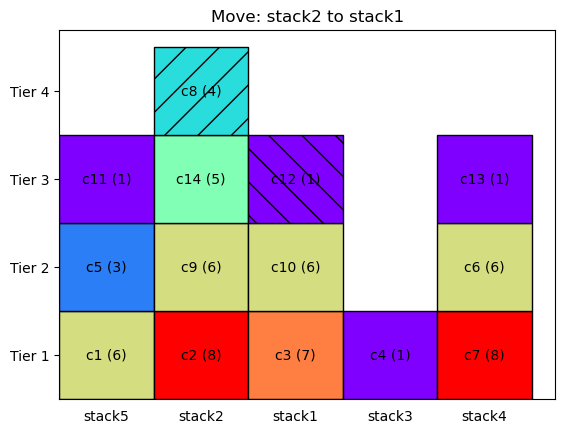

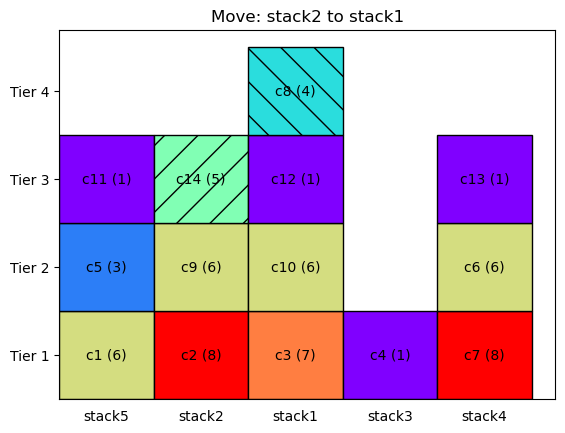

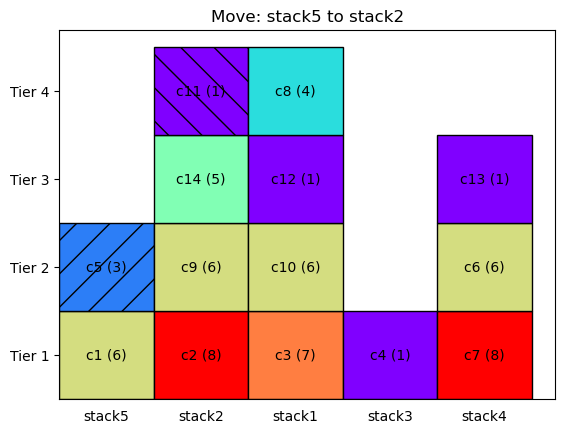

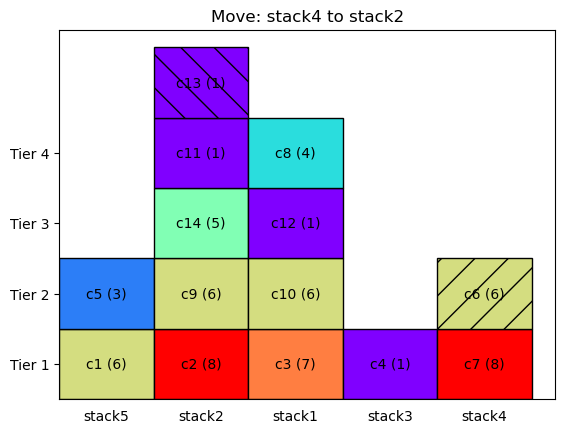

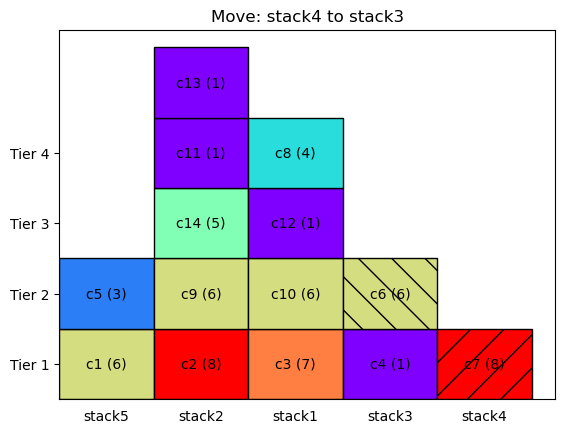

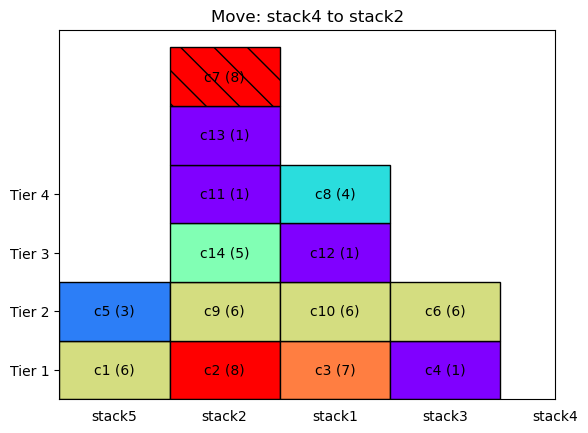

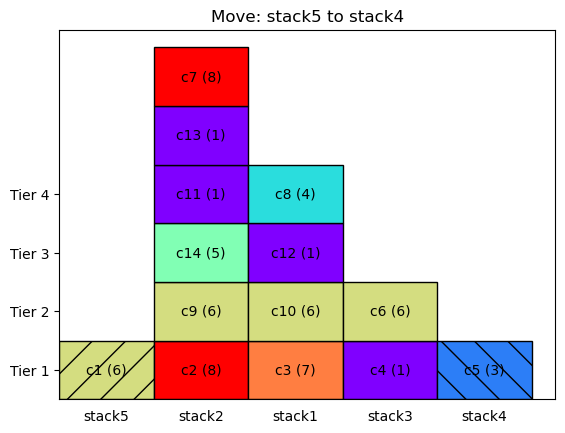

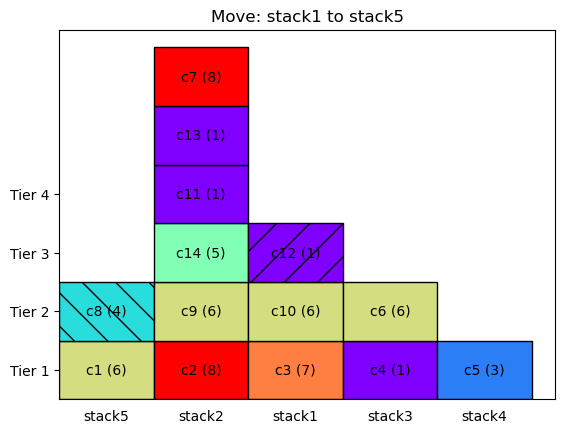

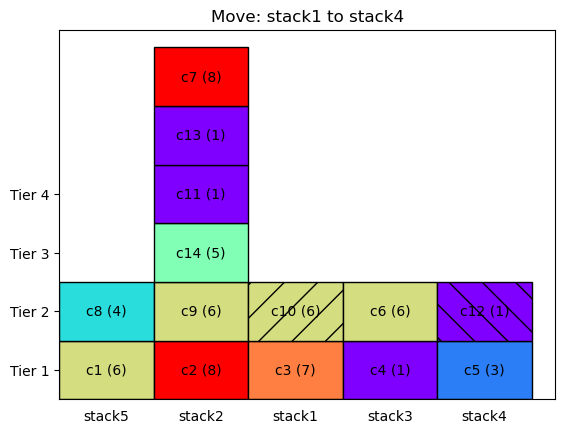

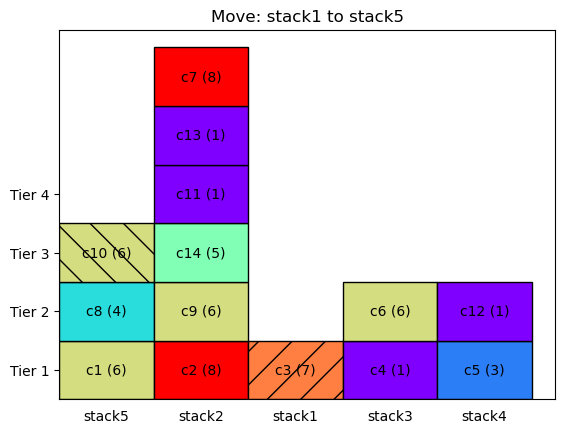

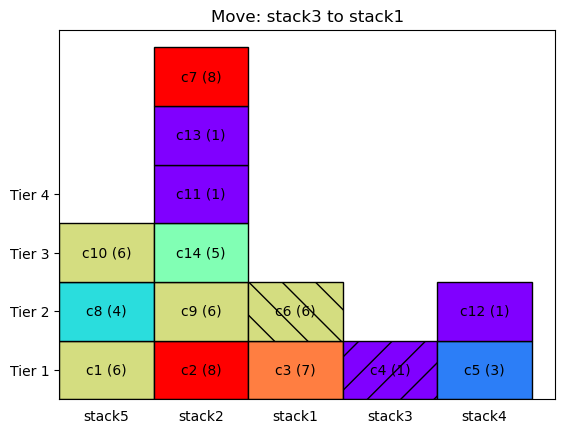

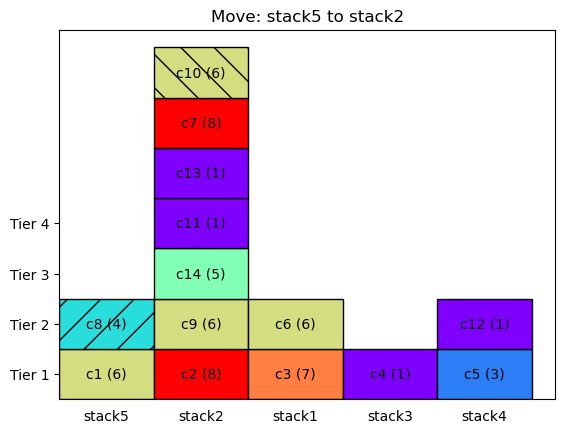

In [566]:
bay={'stack5': [('c1', 6), ('c5', 3), ('c11', 1)],
 'stack2': [('c2', 8), ('c9', 6), ('c14', 5), ('c8', 4), ('c12', 1)],
 'stack1': [('c3', 7), ('c10', 6)],
 'stack3': [('c4', 1)],
 'stack4': [('c7', 8), ('c6', 6), ('c13', 1)]}
P=[('stack2', 'stack1'),
 ('stack2', 'stack1'),
 ('stack5', 'stack2'),
 ('stack4', 'stack2'),
 ('stack4', 'stack3'),
 ('stack4', 'stack2'),
 ('stack5', 'stack4'),
 ('stack1', 'stack5'),
 ('stack1', 'stack4'),
 ('stack1', 'stack5'),
 ('stack3', 'stack1'),
 ('stack5', 'stack2')]

for move in P:
    # Perform the move
    container = bay[move[0]].pop()
    bay[move[1]].append(container)
    # Visualize the bay after the move
    plot_bay_moves(bay, move)